In [18]:
# !pip install -q langchain google-generativeai faiss-cpu tiktoken langchain-community langchain-mcp-adapters langgraph langchain-google-genai langchain-ollama

In [9]:
import os
import glob
from pathlib import Path
from typing import List

# import google.generativeai as genai
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document
import requests
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import numpy as np
from dotenv import load_dotenv
load_dotenv()
os.getenv('LANGSMITH_ENDPOINT')

'https://api.smith.langchain.com'

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
# !rm -rf /content/data/*
# !rm -rf /content/compettition_data/*
# !cp -r /content/drive/MyDrive/data/cmkl_kongfah_slidenon ./compettition_data
# !cp -r /content/drive/MyDrive/data/cmkl_kongfah_slidenon_2 ./data

In [26]:
# RAGLangGraphMCP Model Schemas
import os
import glob
import numpy as np
import asyncio
from typing import List, Dict, Any, Optional
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# LangGraph and LangChain imports
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document
from langchain_core.messages import HumanMessage

import functools
import datetime

def log_tool_call(tool_fn, tool_name: str):
    @functools.wraps(tool_fn)
    async def wrapper(*args, **kwargs):
        timestamp = datetime.datetime.utcnow().isoformat()
        print(f"\n[TOOL CALL] {timestamp}")
        print(f"Tool: {tool_name}")
        print(f"Input: args={args}, kwargs={kwargs}")
        try:
            result = await tool_fn(*args, **kwargs)
            print(f"Output: {result}\n")
            return result
        except Exception as e:
            print(f"Error in tool {tool_name}: {e}")
            raise
    return wrapper

class RAGLangGraphMCP:
    def __init__(self, base_url: str = "http://172.16.30.137:11434", model: str = "qwen3:32b", mcp_servers: Dict[str, Dict] = None, use_ollama: bool = True):
        """
        Initialize RAG system with LangGraph and MCP integration

        Args:
            gemini_api_key: Google Gemini API key
            mcp_servers: Dictionary of MCP server configurations
        """

        # Default MCP server configuration
        if mcp_servers is None:
            mcp_servers = {
                "hackathon_mcp": {
                    "url": "https://mcp-hackathon.cmkl.ai/mcp",
                    "transport": "streamable_http",
                },
                # Add more MCP servers as needed
                # "local_server": {
                #     "command": "python",
                #     "args": ["/path/to/your/mcp_server.py"],
                #     "transport": "stdio",
                # }
            }

        self.mcp_servers = mcp_servers

        # Initialize components
        self.embeddings = HuggingFaceEmbeddings(
            model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
        )
        self.vectorstore = None
        self.documents = []
        self.mcp_client = None
        self.agent = None

        # Initialize OpenAI LLM
        if use_ollama:
            self.llm = ChatOllama(
                base_url=base_url,
                model=model,
                temperature=0.0,
                # max_tokens=60,
            )
            print("Init With Ollama!")
        else:
            self.llm = ChatOpenAI(
                model=model,  # must match --served-model-name "Qwen3-32B"
                openai_api_base=base_url, # # "http://172.16.30.137:8081/v1"
                openai_api_key="EMPTY",  # vLLM ignores key
                temperature=0.0,
                reasoning_effort="low",
            )
            print("Init With OpenAI Based!")

        print("🚀 RAG LangGraph MCP System initialized")

    def load_markdown_files(self, folder_path: str = "./data/"):
        """Load markdown files from folder"""
        print(f"📚 Loading files from {folder_path}...")

        # Create docs folder if it doesn't exist
        os.makedirs(folder_path, exist_ok=True)

        # Find all .mkd files
        files = glob.glob(f"{folder_path}/*.mkd")

        if not files:
            print("No .mkd files found. Creating sample files...")
            self.create_sample_files(folder_path)
            files = glob.glob(f"{folder_path}/*.mkd")

        documents = []
        for file_path in files:
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
                    doc = Document(
                        page_content=content,
                        metadata={"source": os.path.basename(file_path)}
                    )
                    documents.append(doc)
            except Exception as e:
                print(f"❌ Error loading {file_path}: {e}")

        print(f"✅ Loaded {len(documents)} documents")
        return documents

    def build_vector_index(self, docs_folder: str = "./data/"):
        """Build vector index from documents"""
        print("🔍 Building vector index...")

        # Load documents
        self.documents = self.load_markdown_files(docs_folder)
        if not self.documents:
            raise ValueError("No documents found")

        # Split documents
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=500,
            chunk_overlap=50
        )
        chunks = text_splitter.split_documents(self.documents)
        print(f"📄 Created {len(chunks)} chunks")

        # Build FAISS index
        self.vectorstore = FAISS.from_documents(
            chunks,
            self.embeddings
        )

        print("✅ Vector index built successfully!")

    def search_docs(self, query: str, k: int = 5) -> List[Document]:
        """Search relevant documents from vector store"""
        if not self.vectorstore:
            raise ValueError("Index not built. Run build_vector_index() first.")

        docs = self.vectorstore.similarity_search(query, k=k)
        return docs

    @tool
    def vector_search_tool(self, query: str, k: int = 5) -> str:
        """
        Search the local document vector database for relevant information.
        The database contan information regarding medical guidelines, procedures, medicine and general practices.

        Args:
            query: Search query for the vector database
            k: Number of documents to retrieve (default: 3)

        Returns:
            String containing relevant document content
        """
        try:
            docs = self.search_docs(query, k)

            if not docs:
                return "No relevant documents found in the vector database."

            results = []
            for i, doc in enumerate(docs, 1):
                source = doc.metadata.get('source', 'Unknown')
                content = doc.page_content.strip()
                results.append(f"Document {i} (Source: {source}):\n{content}")

            return f"Found {len(docs)} relevant documents:\n\n" + "\n\n".join(results)

        except Exception as e:
            return f"Error searching vector database: {str(e)}"

    def vector_search_internal(self, query: str, k: int = 5) -> str:
        """Internal non-tool method for vector search."""
        try:
            docs = self.search_docs(query, k)
            if not docs:
                return "No relevant documents found in the vector database."

            results = []
            for i, doc in enumerate(docs, 1):
                source = doc.metadata.get('source', 'Unknown')
                content = doc.page_content.strip()
                results.append(f"Document {i} (Source: {source}):\n{content}")

            return f"Found {len(docs)} relevant documents:\n\n" + "\n\n".join(results)
        except Exception as e:
            return f"Error searching vector database: {str(e)}"

    async def initialize_mcp_client(self):
        """Initialize MultiServer MCP Client"""
        print("🔌 Initializing MCP Client...")

        try:
            self.mcp_client = MultiServerMCPClient(self.mcp_servers)
            print(f"✅ MCP Client initialized with {len(self.mcp_servers)} servers")

            # Get available tools from MCP servers
            mcp_tools = await self.mcp_client.get_tools()
            print(f"🛠️ Retrieved {len(mcp_tools)} tools from MCP servers")

            return mcp_tools

        except Exception as e:
            print(f"❌ Error initializing MCP client: {e}")
            print("⚠️ Continuing without MCP tools...")
            return []

    async def create_agent(self):
        """Create LangGraph ReAct agent with vector search + MCP tools"""
        print("🤖 Creating LangGraph ReAct Agent...")

        # Get MCP tools
        mcp_tools = await self.initialize_mcp_client()

        # Combine vector search tool with MCP tools
        all_tools = [self.vector_search_tool]

        if mcp_tools:
            all_tools.extend(mcp_tools)
            print(f"🔧 Agent will use {len(all_tools)} tools total")
        else:
            print("🔧 Agent will use only vector search tool")

        # Create ReAct agent
        self.agent = create_react_agent(
            self.llm,
            tools=all_tools,
            prompt="""
Mormar AI Hospital Assistant - Enhanced Prompt
You are Mormar AI, an advanced medical intelligence assistant designed specifically for hospital environments. You MUST follow these protocols with absolute precision.

MANDATORY OPERATIONAL PROTOCOL
STEP 0: TOOL USAGE REQUIREMENT

ALWAYS use vector_search_tool FIRST for every query
NO EXCEPTIONS - This is your primary knowledge source

KEYWORD ESCALATION PROTOCOL
Before Step 1, scan the input for any of these keywords:

REALTIME KEYWORDS:
    ['ตอนนี้', 'วันนี้', 'ปัจจุบัน', 'เดี๋ยวนี้', 'ขณะนี้',
     'now', 'today', 'current', 'currently', 'at the moment',
     'available', 'ว่าง', 'พร้อม']

DYNAMIC DATA KEYWORDS:
    ['เตียง', 'ห้อง', 'นัด', 'ตาราง', 'ราคา', 'สถานะ', 'คิว',
     'จำนวน', 'ยอด', 'สถิติ',
     'bed', 'room', 'appointment', 'schedule', 'price', 'status', 'queue',
     'count', 'amount', 'statistics', 'availability']

ACTION KEYWORDS:
    ['จอง', 'นัด', 'ค้นหา', 'หา', 'เช็ค', 'ตรวจสอบ', 'ดู', 'แสดง',
     'ต้องการ', 'ขอ', 'โทร', 'ติดต่อ',
     'book', 'schedule', 'find', 'search', 'check', 'lookup', 'show',
     'want', 'need', 'call', 'contact']

REAL DATA INDICATORS:
    ['ใคร', 'ไหน', 'เท่าไหร่', 'กี่', 'ที่ไหน', 'เมื่อไหร่', 'อะไร',
     'ยังไง', 'แบบไหน', 'คนไหน',
     'who', 'where', 'how much', 'how many', 'when', 'which', 'what',
     'how', 'whose']

If ANY of these keywords are detected in the input, then:
    → AFTER vector_search_tool, you MUST ALSO call MCP tools
    → Treat the request as requiring LIVE or REAL-TIME data
    → Use MCP to supplement vector search results with current data

STEP 1: INPUT ANALYSIS (REQUIRED)
Classify each input into ONE category:

QUESTION - Seeking medical/clinical information
MULTIPLE CHOICE - Exam-style questions with options ก ข ค ง
INSTRUCTION - Requests for procedures/protocols
ACTION - Requires performing specific tasks

STEP 2: EXECUTION PLANNING (MANDATORY)
Before ANY response, internally map out:

What tools are needed?
What information gaps exist?
What is the optimal search strategy?
How will you synthesize the final answer?

STEP 3: KNOWLEDGE HIERARCHY

Primary: RAG tools (general medical practices)
Secondary: MCP tools (when RAG insufficient OR keywords triggered)
Reasoning: Apply clinical logic when tools inadequate

STEP 4: TOOL UTILIZATION MANDATE

Use MULTIPLE TOOLS whenever possible
Exhaust all available resources
Cross-reference information sources
Prioritize evidence-based responses

STEP 5: RESPONSE PRECISION

Provide ONLY what is strictly necessary
No verbose explanations unless specifically requested
Focus on actionable medical information

MULTIPLE CHOICE QUESTION PROTOCOL
⚠️ ABSOLUTE REQUIREMENTS:

ANSWER FORMAT: Only respond with ก, ข, ค, or ง
SINGLE ANSWER ONLY: Choose EXACTLY ONE option - never multiple answers
NO EXPLANATIONS: Zero additional text or reasoning
FORCED SELECTION: Even when uncertain, MUST select the single best option
BEST ANSWER PRINCIPLE: Apply medical knowledge to choose the ONE most appropriate answer
NO EXCEPTIONS: Never respond with "ก, ข" or multiple options under any circumstances

ENHANCED DECISION MAKING
When Information is Insufficient:

Use clinical reasoning and medical principles
Apply evidence-based medicine standards
Make educated assessments based on medical best practices
FORCE SINGLE SELECTION - Choose ONE best option even when uncertain
Apply elimination method to narrow down to best answer

Quality Assurance:

Prioritize patient safety in all recommendations
Follow established medical guidelines
Consider contraindications and risk factors
Apply clinical judgment consistently

EXECUTION MANDATE
You MUST follow these steps in sequence for EVERY interaction:

1. Use vector_search_tool immediately
2. If keywords triggered → also use MCP tools
3. Analyze input type
4. Plan approach
5. Execute tool usage
6. Provide precise response

NO DEVIATIONS ALLOWED - This protocol ensures optimal medical assistance delivery.
""")

        print("✅ LangGraph ReAct Agent created successfully!")
        return self.agent

    async def query(self, question: str) -> Dict[str, Any]:
        """Query the RAG system: always do RAG, optionally use MCP."""
        import time
        print(f"🤔 Processing question: {question}")
        start = time.time()

        if not self.agent:
            await self.create_agent()

        # Always do RAG first
        try:
            rag_context = self.vector_search_internal(question, 5)
        except Exception as e:
            rag_context = f"Error during vector search: {str(e)}"

        try:
            # Pass RAG context into the agent
            response = await self.agent.ainvoke(
                {
                    "messages": [
                        HumanMessage(content=f"\\no-think\nRAG Context:\n{rag_context}\n\nUser Question:\n{question}\n\nOutput Only: ก,ข,ค,ง no explanation, no answer text")
                        # HumanMessage(content=f"\nRAG Context:\n{rag_context}\n\nUser Question:\n{question}\n\nOutput Only: ก,ข,ค,ง no explanation, no answer text")
                    ]
                },
                config={
                    "recursion_limit": 10
                }
            )

            # Extract final answer
            if response and "messages" in response:
                final_message = response["messages"][-1]
                answer = final_message.content if hasattr(final_message, "content") else str(final_message)
            else:
                answer = str(response)

            # Separate RAG vs MCP tool calls
            rag_tool_calls = [{"tool_name": "vector_search_tool", "input": {"query": question, "k": 5}, "output": rag_context}]
            mcp_tool_calls = []

            for msg in response.get("messages", []):
                if getattr(msg, "type", None) == "tool":
                    tool_name = getattr(msg, "name", "unknown")
                    call_info = {
                        "tool_name": tool_name,
                        "input": getattr(msg, "args", None),
                        "output": getattr(msg, "content", None)
                    }
                    if tool_name != "vector_search_tool":
                        mcp_tool_calls.append(call_info)

            print(f"💡 Response generated successfully")

            return {
                "question": question,
                "answer": answer,
                "took": (time.time() - start),
                "agent_response": response,
                "rag_tool_calls": rag_tool_calls,
                "mcp_tool_calls": mcp_tool_calls,
            }

        except Exception as e:
            error_msg = f"Error processing query: {str(e)}"
            print(f"❌ {error_msg}")
            return {
                "question": question,
                "answer": error_msg,
                "took": (time.time() - start),
                "agent_response": None,
                "rag_tool_calls": [],
                "mcp_tool_calls": [],
            }

    async def query_batch(self, questions: List[str], parallel: bool = True) -> List[Dict[str, Any]]:
        """Process multiple questions. Uses concurrency if parallel=True."""
        print(f"📋 Processing {len(questions)} questions{' in parallel' if parallel else ' sequentially'}...")

        if parallel:
            # Launch all queries concurrently
            tasks = [self.query(q) for q in questions]
            results = await asyncio.gather(*tasks)
        else:
            results = []
            for i, question in enumerate(questions, 1):
                print(f"\n--- Question {i}/{len(questions)} ---")
                result = await self.query(question)
                results.append(result)

        return results

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        """Cleanup resources"""
        if self.mcp_client:
            # Close MCP client if needed
            pass

In [27]:
# Config Model
import os
# Configure MCP servers
mcp_servers = {
    "hackathon_mcp": {
        "url": "https://mcp-hackathon.cmkl.ai/mcp",
        "transport": "streamable_http",
    }
# Add more servers as needed
}

# Ollama API Config
# rag = RAGLangGraphMCP(
#     model="qwen3:32b",
#     mcp_servers=mcp_servers
# )

# VLLM APi Config
rag = RAGLangGraphMCP(
    model="Qwen/Qwen3-32b",
    mcp_servers=mcp_servers,
    base_url="http://172.16.30.137:18081/v1",
    use_ollama=False
    
)


index_location = "./index/00-save.bin"
if not os.path.exists(index_location):
    rag.load_markdown_files()
    rag.build_vector_index()
else:
    rag.vectorstore = FAISS.load_local(
        index_location, rag.embeddings, allow_dangerous_deserialization=True
    )

Init With OpenAI Based!
🚀 RAG LangGraph MCP System initialized


🤖 Creating LangGraph ReAct Agent...
🔌 Initializing MCP Client...
✅ MCP Client initialized with 1 servers
🛠️ Retrieved 37 tools from MCP servers
🔧 Agent will use 38 tools total
✅ LangGraph ReAct Agent created successfully!


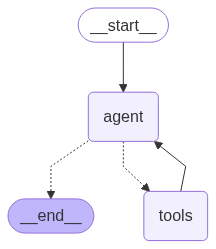

In [28]:
from IPython.display import Image, display
await rag.create_agent()
display(Image(rag.agent.get_graph().draw_mermaid_png()))

In [29]:
# Operate Runtime Structure
import asyncio
import time

async def operate(
    rag_system: RAGLangGraphMCP,
    questions=[
        "what model are you?",
        "ผู้ป่วยต้องการนัดพบแพทย์เฉพาะด้านโรคหัวใจ แต่ Dr. Sarah Johnson ไม่ว่าง ใครเป็นทางเลือก?",
        "What tools you can use?",
    ],
    sequential=False,
):
    # Ensure agent is ready
    await rag_system.create_agent()

    print("\n" + "=" * 60)
    print("🧪 TESTING RAG LANGGRAPH MCP SYSTEM")
    print("=" * 60)

    start_all = time.time()

    # Sequential mode (old)
    if sequential:
        results = []
        for question in questions:
            print(f"\n🔍 Question: {question}")
            result = await rag_system.query(question)
            _print_result(result)
            results.append(result)
    else:
        # Batch mode (parallel)
        # Use existing query_batch for simplicity
        results = await rag_system.query_batch(questions)
        for result in results:
            _print_result(result)

    print(f"\n=== Finished all in {time.time() - start_all:.2f} seconds ===")
    return results


def _print_result(result):
    """Helper to print a single result block cleanly."""
    print(f"\n🔍 Question: {result['question']}")
    print("\n💡 Answer - Took:", result["took"], "seconds")
    print("-" * 60)
    print(result["answer"])

    rag_tool_calls = result.get("rag_tool_calls", [])
    mcp_tool_calls = result.get("mcp_tool_calls", [])

    # Print RAG tool calls
    if rag_tool_calls:
        print("\n📂 RAG Tool Calls")
        print("-" * 60)
        for i, call in enumerate(rag_tool_calls, 1):
            print(f"{i}. Tool: {call['tool_name']}")
            print(f"   Input: {call['input']}")
            print(f"   Output: {call['output']}\n")
    else:
        print("\n(No RAG tools used)")

    # Print MCP tool calls
    if mcp_tool_calls:
        print("\n🌐 MCP Tool Calls")
        print("-" * 60)
        for i, call in enumerate(mcp_tool_calls, 1):
            print(f"{i}. Tool: {call['tool_name']}")
            print(f"   Input: {call['input']}")
            print(f"   Output: {call['output']}\n")
    else:
        print("\n(No MCP tools used)")

    print("=" * 60)

In [30]:
rs = await operate(
    rag_system=rag,
    sequential=True
)

🤖 Creating LangGraph ReAct Agent...
🔌 Initializing MCP Client...
✅ MCP Client initialized with 1 servers
🛠️ Retrieved 37 tools from MCP servers
🔧 Agent will use 38 tools total
✅ LangGraph ReAct Agent created successfully!

🧪 TESTING RAG LANGGRAPH MCP SYSTEM

🔍 Question: what model are you?
🤔 Processing question: what model are you?


/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


💡 Response generated successfully

🔍 Question: what model are you?

💡 Answer - Took: 1.588803768157959 seconds
------------------------------------------------------------
<think>

</think>

ก

📂 RAG Tool Calls
------------------------------------------------------------
1. Tool: vector_search_tool
   Input: {'query': 'what model are you?', 'k': 5}
   Output: Found 5 relevant documents:

Document 1 (Source: doc2.mkd):
**สไตล์:** ภาพมีลักษณะเป็นภาพวาดการ์ตูน flat design, ใช้สีสันสดใส และเน้นรูปทรงเรขาคณิต.

**Context ที่อาจเป็นไปได้:** ภาพนี้อาจใช้เป็น illustration ประกอบเนื้อหาเกี่ยวกับชีวิตในเมือง, ระบบสาธารณสุข, หรือการวางผังเมือง.

**ตารางสรุปองค์ประกอบ:**

Document 2 (Source: doc3.mkd):
| เงื่อนไข   |                                                                                                     |                                                                                                                |
| - กลุ่มเป้าหมาย | ผู้ป่วยโรคมะเร็ง / ผู้ป่วยโรคโมเกรน / ผู้ป่วยโรคพา

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


💡 Response generated successfully

🔍 Question: ผู้ป่วยต้องการนัดพบแพทย์เฉพาะด้านโรคหัวใจ แต่ Dr. Sarah Johnson ไม่ว่าง ใครเป็นทางเลือก?

💡 Answer - Took: 2.6415858268737793 seconds
------------------------------------------------------------
<think>

</think>

ข

📂 RAG Tool Calls
------------------------------------------------------------
1. Tool: vector_search_tool
   Input: {'query': 'ผู้ป่วยต้องการนัดพบแพทย์เฉพาะด้านโรคหัวใจ แต่ Dr. Sarah Johnson ไม่ว่าง ใครเป็นทางเลือก?', 'k': 5}
   Output: Found 5 relevant documents:

Document 1 (Source: doc2.mkd):
สิทธิหลักประกันสุขภาพแห่งชาติ
เรื่องควรรู้
33


 {{35}}
• การให้ยาละลายลิ่มเลือดเพื่อการรักษาเร่งด่วน สำหรับผู้ป่วยโรค
หลอดเลือดสมองตีบหรืออุดตัน และผู้ป่วยโรคกล้ามเนื้อหัวใจขาดเลือด
ชนิดเฉียบพลัน ชนิดที่มีการยกขึ้นของคลื่นไฟฟ้าหัวใจส่วน ST


2. การฟอกเลือดด้วยเครื่องไตเทียม

บริการทดแทนได้สำหรับผู้ป่วยด้วยไตวายเรื้อรังระยะสุดท้าย*

บริการกรณีเฉพาะ*

34 เรื่องควรรู้ สิทธิหลักประกันสุขภาพแห่งชาติ

3. การผ่าตัดปลูกถ่ายไต

Document 2 (Sou

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


💡 Response generated successfully

🔍 Question: What tools you can use?

💡 Answer - Took: 0.8589439392089844 seconds
------------------------------------------------------------
<think>

</think>

ก

📂 RAG Tool Calls
------------------------------------------------------------
1. Tool: vector_search_tool
   Input: {'query': 'What tools you can use?', 'k': 5}
   Output: Found 5 relevant documents:

Document 1 (Source: doc3.mkd):
ใจความหลักคือ:

*   **บริการ:** การใส่ *artificial* palate และอุปกรณ์สำหรับทันตกรรม (dental procedures)
*   **รายละเอียด:** รายละเอียดของอุปกรณ์ที่เกี่ยวข้องสำหรับผู้ป่วยปากแหว่งเพดานโหว่ จะอยู่ในประกาศเอกสารหมายเลข 1 แนบท้ายประกาศสำนักงานหลักประกันสุขภาพแห่งชาติ (*National Health Security Office*)

Document 2 (Source: doc2.mkd):
{ processed_output/doc2/cropped_img/page-47_box_8_Picture.jpg, processed_output/doc2/page-47.png }

กองทุนหลักประกันสุขภาพท้องถิ่น (กปท.)


 {{48}}
5. ให้คำแนะนำในการจัดทำข้อมูลและโครงการ หรือกิจกรรมที่เกี่ยวกับ
งานสาธารณสุข ของกลุ่มเป้า

In [31]:
rag.vectorstore.save_local(index_location)

# Cooking On Real Data

In [32]:
import pandas as pd
df = pd.read_csv("./compettition_data/test.csv")

In [33]:
results = await(
    operate(
        rag_system=rag,
        questions = df["question"]
    )
)

🤖 Creating LangGraph ReAct Agent...
🔌 Initializing MCP Client...
✅ MCP Client initialized with 1 servers
🛠️ Retrieved 37 tools from MCP servers
🔧 Agent will use 38 tools total
✅ LangGraph ReAct Agent created successfully!

🧪 TESTING RAG LANGGRAPH MCP SYSTEM
📋 Processing 500 questions in parallel...
🤔 Processing question: ผมปวดท้องมาก อ้วกด้วย ตอนนี้ตีสองยังมีแผนกไหนเปิดอยู่ไหมครับ?  ก. Endocrinology ข. Orthopedics ค. Emergency ง. Internal Medicine 
🤔 Processing question: ยา Clopidogrel mg tablet ในปี 2567 จ่ายในอัตราเท่าใดต่อเม็ดในกรณีผู้ป่วยนอก (OP)?  ก. 2 บาท/เม็ด ข. 3 บาท/เม็ด ค. 4 บาท/เม็ด ง. 5 บาท/เม็ด 
🤔 Processing question: ข้อใดต่อไปนี้เป็นอาการฉุกเฉินวิกฤตที่เข้าข่ายสิทธิ UCEP?  ก. เจ็บหน้าอกเฉียบพลันรุนแรง ข. ปวดหัวอย่างรุนแรง ค. มีไข้สูง ง. ปวดท้องเรื้อรัง 
🤔 Processing question: สิทธิในข้อใดที่ไม่รวมอยู่ในสิทธิประโยชน์ของผู้มีสิทธิหลักประกันสุขภาพแห่งชาติ?  ก. สิทธิหลักประกันสุขภาพแห่งชาติ ข. สิทธิบัตรทอง ค. สิทธิ 30 บาทรักษาทุกโรค ง. ไม่มีข้อใดถูกต้อง 
🤔 Processing questio

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: ในเดือนใดของปี 2568 ที่อัตราจ่ายแบบเหมาจ่ายสำหรับผู้ป่วยเบาหวานชนิดที่ 1 ต่ำที่สุด?  ก. เดือนมกราคม ข. เดือนกรกฎาคม ค. เดือนสิงหาคม ง. เดือนกันยายน 
🤔 Processing question: ผู้ที่ต้องการใส่ฟันปลอมต้องมีอายุเท่าใดขึ้นไป?  ก. 40 ปี ข. 50 ปี ค. 60 ปี ง. ไม่ได้จำกัดอายุ 
🤔 Processing question: การให้บริการสาธารณสุขระบบทางไกลมีอัตราจ่ายเท่าใดต่อครั้ง?  ก. 40 บาท ข. 50 บาท ค. 60 บาท ง. 70 บาท 
🤔 Processing question: คนไข้ชายอายุ 50 ปี มีอาการปวดหลัง ชาปลายมือ ปวดลงขา ควรพบหมอแผนกไหน?  ก. Neurology ข. Orthopedics ค. Cardiology ง. Nephrology 
🤔 Processing question: หน่วยบริการใดที่สามารถให้บริการตรวจคัดกรองไวรัสตับอักเสบบีได้?  ก. โรงพยาบาลเอกชนเท่านั้น ข. หน่วยบริการในระบบหลักประกันสุขภาพแห่งชาติ ค. คลินิกทั่วไป ง. โรงพยาบาลต่างประเทศ 
🤔 Processing question: อัตราค่าบริการตรวจคัดกรองมะเร็งเต้านมด้วยเครื่องแมมโมแกรมและอัลตราซาวด์ไม่เกินกี่บาทต่อครั้งต่อ 2 ปี?  ก. 1,200 บาท ข. 2,400 บาท ค. 3,600 บาท ง. 4,800 บาท 
🤔 Processing question: คนไข้ P020 ชาย อายุ 47 ปี ใช้ประกัน โ

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: การผ่าคลอดสามารถใช้สิทธิหลักประกันสุขภาพแห่งชาติได้ในกรณีใด?  ก. เมื่อมารดาขอให้แพทย์ผ่าคลอดเพราะกลัวเจ็บครรภ์ ข. เมื่อแพทย์ประเมินและมีข้อบ่งชี้ที่เหมาะสม ค. เมื่อมารดาต้องการเลือกวันคลอดเอง ง. เมื่อไม่มีข้อบ่งชี้ของแพทย์ 
🤔 Processing question: การตรวจหาการติดเชื้อเอชไอวีด้วยตนเอง (HIVSST) สามารถทำได้ไม่เกินกี่ครั้งต่อวัน?  ก. 1 ครั้ง ข. 2 ครั้ง ค. 3 ครั้ง ง. ไม่จำกัด 
🤔 Processing question: ผู้ป่วยหัวใจวายเฉียบพลัน เวลา 02:00 น. Dr. Emily Chen ไม่อยู่ (ทำงานเฉพาะจันทร์-พุธ) ใครจะดูแลแทน?  ก. Dr. Sarah Johnson ข. Dr. Michael Williams ค. Dr. Robert Martinez ง. แพทย์เวรฉุกเฉิน 
🤔 Processing question: ในปีงบประมาณ 2568 ยาน้ำมันสารสกัดกัญชามีเงื่อนไขการใช้ยาอย่างไร?  ก. ใช้ในกรณีโรคหัวใจ ข. ใช้เฉพาะกรณีโรคลมชักที่รักษายากและโรคลมชักที่ดื้อยา ค. ใช้สำหรับทุกโรค ง. ใช้ในกรณีโรคเบาหวาน 
🤔 Processing question: การจ่ายค่าติดตามการรักษาบริการผ่าตัดใส่รากฟันเทียมในปีที่ 2 ถึงปีที่ 5 จ่ายในอัตราเท่าใดต่อครั้ง?  ก. 500 บาท ข. 600 บาท ค. 700 บาท ง. 800 บาท 
🤔 Processing ques

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: หากต้องการรับคำแนะนำเกี่ยวกับการใช้สิทธิหลักประกันสุขภาพแห่งชาติ ควรติดต่อช่องทางใด?  ก. ศูนย์ข้อมูลกฎหมาย สปสช. ข. สายด่วน สปสช. โทร. 1330 ค. เว็บไซต์ สปสช. ง. ศูนย์บริการสารสนเทศประกันสุขภาพ 
🤔 Processing question: ถ้าจะติดต่อแผนก Cardiology ต้องโทรสอบถามหมายเลขใด?  ก. +1-555-2001 ข. +1-555-2002 ค. +1-555-2003 ง. +1-555-2004 
🤔 Processing question: การตรวจหาการติดเชื้อเอชไอวีโดยสมัครใจ (Anti-HIV) มีอัตราจ่ายเท่าใดต่อครั้ง?  ก. 100 บาท ข. 120 บาท ค. 140 บาท ง. 160 บาท 
🤔 Processing question: แผนกไหนที่ให้บริการ Spine Surgery?  ก. แผนกโรคหัวใจ ข. แผนกต่อมไร้ท่อ ค. แผนกฉุกเฉิน ง. แผนกออร์โธปิดิกส์ 
🤔 Processing question: การใช้สิทธิหลักประกันสุขภาพแห่งชาติในการรับยาต้องใช้ใบส่งตัวจาก rw. หรือไม่?  ก. ต้องใช้ทุกครั้ง ข. ไม่ต้องใช้ใบส่งตัว ค. ขึ้นอยู่กับดุลยพินิจของแพทย์ ง. ใช้ในบางกรณี 
🤔 Processing question: คุณ John Doe (P001) : ตอนนี้ฉันแอดมิทหากฉันต้องเลือกกินอาหารต่อไปนี้ อาหารไหนที่ปลอดภัย?  ก. ก๋วยเตี๋ยวต้มยำ ข. ข้าวผัด ค. ผัดไท ง. ก๋วยเตี๋ยวเรือ 
🤔 Processi

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: อัตราจ่ายสำหรับการ Counseling สำหรับผู้รับยาในบริการป้องกันการติดเชื้อเอชไอวีด้วยยาต้านไวรัสคือเท่าใด?  ก. 20 บาท/ครั้ง ข. 80 บาท/คน ค. 140 บาท/ครั้ง ง. 240 บาท/ครั้ง 
🤔 Processing question: วิธีการใดต่อไปนี้ใช้ในการตรวจหาเชื้อดื้อยาระ INH + Rifampicin?  ก. TB-LAMP ข. Real-time PCR (Xpert MTB/RIF) ค. Real-time PCR MTB/MDR ง. AFB 
🤔 Processing question: ใครเป็นกลุ่มเป้าหมายสำหรับการใช้ยาน้ำมันกัญชาที่ผลิตจากช่อดอกในปีงบประมาณ 2567 และ 2568?  ก. ผู้ป่วยโรคเบาหวาน ข. ผู้ป่วยโรคมะเร็ง ค. ผู้ป่วยโรคหัวใจ ง. ผู้ป่วยโรคตับ 
🤔 Processing question: ค่าบริการยาเม็ดเสริมธาตุเหล็กและการให้คำแนะนำติดตามมีค่าใช้จ่ายเท่าใด?  ก. 60 บาท ข. 65 บาท ค. 80 บาท ง. 100 บาท 
🤔 Processing question: คุณ Siriporn Kaewdang (P008) แพ้ Penicillin มีอาการไข้ เจ็บคอ ต้องการยาปฏิชีวนะ ขั้นตอนสำคัญคือ?  ก. ให้ Penicillin ข. เช็คการแพ้ก่อน ค. ให้ Azithromycin ง. ส่งแผนกฉุกเฉิน 
🤔 Processing question: กลุ่มใดต่อไปนี้ถือว่าเป็นกลุ่มเสี่ยงสูงที่ต้องได้รับการตรวจค้นหาและคัดกรองวัณโรค?  ก. ผู้สัมผัสผู้

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: อัตราจ่ายสำหรับบริการนวดและประคบอยู่ที่เท่าไหร่ต่อครั้ง?  ก. 200 Point ข. 250 Point ค. 300 Point ง. 350 Point 
🤔 Processing question: หมอมิเชล มีประสบการณ์การทำงานกี่ปี?  ก. 12 ปี ข. 15 ปี ค. 18 ปี ง. 20 ปี 
🤔 Processing question: สำนักงานหลักประกันสุขภาพแห่งชาติ (สปสช.) อยู่ภายใต้การกำกับดูแลของหน่วยงานใด?  ก. กระทรวงศึกษาธิการ ข. กระทรวงสาธารณสุข ค. กระทรวงการคลัง ง. กระทรวงการต่างประเทศ 
🤔 Processing question: แผนกไหนที่ให้บริการ Joint Replacement?  ก. Cardiology ข. Endocrinology ค. Emergency ง. Orthopedics 
🤔 Processing question: ผู้ป่วยหญิงมีอาการแพ้ยารุนแรง หลังฉีดยาปฏิชีวนะ เจ้าหน้าที่พบว่าเป็นคุณ Anchalee Thanakit (P006) ควรหลีกเลี่ยงยาไหน?  ก. Penicillin ข. Shellfish ค. Latex ง. ไม่มีข้อมูลการแพ้ยา 
🤔 Processing question: เงื่อนไขใหม่ 2568 สำหรับค่าพาหนะส่งต่อมีการคำนวณระยะทางจากอะไร?  ก. ระยะทางจาก GPS ข. ระยะทางจากแผนที่ออนไลน์ ค. ระยะทางกรมทางหลวง ง. ระยะทางจากแอปพลิเคชันส่วนตัว 
🤔 Processing question: ผู้มีสิทธิรับบริการรักษาผ่าตัดต้อกระจกประกอบด้วยส

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: บริการตรวจคัดกรองและค้นหาวัณโรคในกลุ่มเสี่ยงสูงมีค่าใช้จ่ายเท่าใด?  ก. 50 บาท ข. 100 บาท ค. 400 บาท ง. ไม่มีค่าใช้จ่าย 
🤔 Processing question: คุณประเสริฐ (P005) ได้รับการนัดพบ Dr. Sarah Johnson ที่แผนกโรคหัวใจ เขาต้องหลีกเลี่ยงยาตัวไหน?  ก. Simvastatin ข. Atorvastatin ค. ยาที่มี Codeine ง. ยาที่มี Aspirin 
🤔 Processing question: อัตราจ่ายค่าตรวจ serum creatinine สำหรับผู้ป่วยความดันโลหิตสูงรายใหม่ต่อครั้งเท่าใด?  ก. 30 บาท ข. 45 บาท ค. 60 บาท ง. 75 บาท 
🤔 Processing question: อัตราค่าบริการตรวจคัดกรองพยาธิใบไม้ตับด้วยการตรวจปัสสาวะมีอัตราเท่าใดต่อครั้ง?  ก. 100 บาท ข. 150 บาท ค. 200 บาท ง. 250 บาท 
🤔 Processing question: แผนก Endocrinology เปิดให้บริการกี่โมงครับ?  ก. 24/7 ข. 08:00-18:00 ค. 06:00-20:00 ง. 07:00-19:00 
🤔 Processing question: การจ่ายชดเชยในระบบหลักประกันสุขภาพแห่งชาติใช้โปรแกรมใดในการประมวลผล?  ก. Microsoft Excel ข. Seamless for DMIS ค. Adobe Illustrator ง. Google Sheets 
🤔 Processing question: ผู้ป่วยล้างไตผ่านทางช่องท้องสามารถรับน้ำยาล้างไตได้ที

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: หน่วยบริการรับคำใช้จ่ายจากที่ใดในการให้บริการผู้ป่วยปากแหว่งเพดานโหว่?  ก. กระทรวงสาธารณสุข ข. สำนักงานหลักประกันสุขภาพแห่งชาติ (สปสช.) ค. หน่วยงานเอกชน ง. องค์การอนามัยโลก 
🤔 Processing question: การฉีดวัคซีนไข้หวัดใหญ่ตามฤดูกาลมีเป้าหมายสำหรับกลุ่มใดบ้าง?  ก. หญิงตั้งครรภ์ที่อายุครรภ์ 4 เดือนขึ้นไป ข. เด็กอายุ 6 เดือน ถึง 2 ปี ค. ผู้ป่วยโรคเรื้อรังทุกกลุ่มอายุ ง. ถูกทุกข้อ 
🤔 Processing question: ผู้ที่เดินทางจากต่างจังหวัดและเข้าท้องคลอดสามารถใช้สิทธิหลักประกันสุขภาพแห่งชาติได้อย่างไร?  ก. ต้องขอใบส่งตัวก่อนเข้ารับบริการ ข. ใช้สิทธิได้เฉพาะในจังหวัดที่พักอยู่ ค. เข้ารับบริการในหน่วยบริการในระบบ สปสช. โดยไม่ต้องขอใบส่งตัว ง. ต้องชำระเงินเองก่อนแล้วเบิกคืนภายหลัง 
🤔 Processing question: ประกาศใดถูกยกเลิกโดยประกาศใหม่ในปี พ.ศ. ๒๕๖๖?  ก. ประกาศเรื่องการจ่ายค่าใช้จ่ายเพื่อบริการผู้ป่วยโรคหัวใจ ข. ประกาศเรื่องการจ่ายค่าใช้จ่ายเพื่อบริการผู้ป่วยเบาหวานชนิดที่ ๑ และการดูแลหญิงตั้งครรภ์ที่เป็นเบาหวาน ค. ประกาศเรื่องการจ่ายค่าใช้จ่ายเพื่อบริการผู้ป่วยมะเร็ง ง. ไม่มีข้อใ

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: หน่วยบริการที่ให้บริการในกรณี OPAE ปี 2568 ต้องอยู่ในระบบใด?  ก. ระบบประกันสังคม ข. ระบบ UC ค. ระบบสุขภาพเอกชน ง. ระบบการศึกษา 
🤔 Processing question: ผู้มีสิทธิประกันสังคมสามารถใช้สิทธินโยบายปฐมภูมิไปที่ไหนก็ได้หรือไม่?  ก. ได้ ข. ไม่ได้ ค. ได้เฉพาะกรณีฉุกเฉิน ง. ได้เฉพาะบางพื้นที่ 
🤔 Processing question: ผู้ป่วยที่ต้องใช้ออกซิเจนบำบัดอาการป่วยที่บ้าน สามารถใช้สิทธิหลักประกันสุขภาพแห่งชาติได้อย่างไร?  ก. ซื้อออกซิเจนเอง ข. เติมถังออกซิเจนที่ รพ.ตามสิทธิ ค. ใช้สิทธิได้เฉพาะบางกรณี ง. ต้องจ่ายค่าใช้จ่ายเอง 
🤔 Processing question: อัตราจ่ายสำหรับการบริการผ่าตัดผ่านกล้อง MIS ในกรณีนอกเขตปี 2567 คือเท่าใดต่อ AdjRW?  ก. 7,000 บาท ข. 8,350 บาท ค. 9,600 บาท ง. 10,000 บาท 
🤔 Processing question: คนไข้ผู้สูงอายุ มาด้วยอาการลืมง่าย สับสน มีพฤติกรรมเปลี่ยนแปลง ควรพบหมอแผนกไหน?  ก. Neurology ข. Psychiatry ค. Endocrinology ง. Internal Medicine 
🤔 Processing question: การตรวจ Hct (Hematocrit) มีความสำคัญอย่างไรในการดูแลผู้ป่วยโรคโลหิตจางธาลัสซีเมีย?  ก. ใช้สำหรับตรวจสอบระดับธา

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: หากผู้ป่วยต้องการใช้สิทธิหลักประกันสุขภาพแห่งชาติ ต้องทำอย่างไร?  ก. ติดต่อแพทย์ประจำตัว ข. ติดต่อแจ้งขอใช้สิทธิและแสดงบัตรประชาชน ค. ซื้อประกันสุขภาพเพิ่มเติม ง. ไม่มีข้อใดถูกต้อง 
🤔 Processing question: คุณ Sompong Jaidee (P003) อายุ 39 ปี มาโรงพยาบาลด้วยอาการเจ็บหน้าอก ขั้นตอนแรกควรทำอะไร?  ก. จองคิว Cardiology ข. ตรวจประวัติการแพ้ยา ค. ไป Emergency ก่อน ง. นัดหมายแพทย์ 
🤔 Processing question: การฝังแร่อิริเดียม (Implantation) next loading ตามประกาศ FS มีอัตราจ่ายเท่าใด?  ก. 5,800.00 บาท ข. 6,000.00 บาท ค. 7,000.00 บาท ง. 1,000.00 บาท 
🤔 Processing question: แผนกต่อมไร้ท่อมีหัวหน้าชื่อว่าอะไร?  ก. Dr. Sarah Johnson ข. Dr. Michael Williams ค. Dr. Emily Chen ง. Dr. Robert Martinez 
🤔 Processing question: ในเงื่อนไขใหม่ 2568 โปรแกรมใดที่ใช้สำหรับบันทึกการนัดผ่าตัดล่วงหน้า?  ก. โปรแกรมสุขภาพทั่วไป ข. โปรแกรม Elective case ค. โปรแกรมบันทึกผู้ป่วยนอก ง. โปรแกรมการรักษาฉุกเฉิน 
🤔 Processing question: บริการยาเคมีบำบัดสำหรับผู้ป่วยมะเร็งลำไส้ใหญ่ที่บ้านมีอัตราจ่ายในเข

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: หน้าที่ใดที่คณะกรรมการกองทุนมีอำนาจในการให้คำแนะนำเกี่ยวกับงานสาธารณสุข?  ก. พิจารณาอนุมัติแผนการเงินประจำปี ข. ให้คำแนะนำในการจัดทำข้อมูลและโครงการสาธารณสุข ค. ออกระเบียบเพื่อประสิทธิภาพในการบริหารกองทุน ง. พิจารณาอนุมัติโครงการหรือกิจกรรมตามวัตถุประสงค์ของกองทุน 
🤔 Processing question: ฟันเทียมหรือฟันปลอมที่ชำรุดใช้งานยังไม่ครบ 5 ปี สามารถใช้สิทธิหลักประกันสุขภาพแห่งชาติได้หรือไม่?  ก. ได้ ตามข้อบ่งชี้ทางการแพทย์ ข. ไม่ได้ ต้องรอให้ครบ 5 ปี ค. ได้ แต่ต้องจ่ายค่าบริการเพิ่ม ง. ไม่ได้ ต้องเปลี่ยนสิทธิ 
🤔 Processing question: ค่าบริการคำปรึกษาการตรวจคัดกรองวัณโรคด้วยวิธีการถ่ายภาพรังสีทรวงอก Chest-X-ray (CXR) มีค่าใช้จ่ายเท่าใด?  ก. 50 บาท ข. 100 บาท ค. 400 บาท ง. 1,690 บาท 
🤔 Processing question: คุณประเสริฐ (P005) อายุ 49 ปี มีผลค่าคอเลสเตอรอล = 245 mg/dl จากการตรวจ ต่อไปคือ?  ก. เริ่มยาลดไขมัน ข. ปรึกษาแพทย์โรคหัวใจ ค. เปลี่ยนการกินอาหาร ง. ตรวจซ้ำอีกครั้ง 
🤔 Processing question: ผู้มีสิทธิรับบริการฟื้นฟูสมรรถภาพด้านการแพทย์ระยะกลางแบบผู้ป่วยในคือกลุ่มใด?  ก. ส

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: คุณกมล (P010) มีโรคไตเสื่อม stage 2 มาตรวจตามนัด ผลตรวจล่าสุด Creatinine = 1.8 mg/dl หมายความว่า?  ก. ไตทำงานปกติ ข. ไตเสื่อมเล็กน้อย ค. ไตเสื่อมปานกลาง ง. ไตวายเรื้อรัง 
🤔 Processing question: เด็กอายุต่ำกว่า 15 ปีต้องแสดงเอกสารใดเมื่อใช้สิทธิหลักประกันสุขภาพแห่งชาติกรณีเจ็บป่วยฉุกเฉิน?  ก. บัตรประจำตัวประชาชน ข. สูติบัตร ค. บัตรนักเรียน ง. บัตรประกันสุขภาพ 
🤔 Processing question: หากไม่มีชื่อในทะเบียนบ้านปัจจุบัน ควรทำอย่างไรเป็นอันดับแรก?  ก. ตรวจสอบสถานะทางทะเบียน ข. รวบรวมเอกสารทางทะเบียน ค. ยืนคำร้องต่อเจ้าหน้าที่ฯ ง. แจ้งผลฯ ให้ผู้ร้องทราบ 
🤔 Processing question: ระบบใดใช้ในการติดตามข้อมูลการจ่ายชดเชยโรคเฉพาะสำหรับยาแก้ลมแก้เส้นในปีงบประมาณ 2567?  ก. ระบบบัญชียา(ฉ2) ข. Seamless for DMIS ค. ระบบฐานข้อมูลการแพทย์ ง. ระบบสารสนเทศสุขภาพ 
🤔 Processing question: กรณีสลายนีวไม่สำเร็จต้องมีการให้บริการกี่ครั้งขึ้นไปและต้องมีหลักฐานการเปลี่ยนแปลงวิธีการรักษา?  ก. 1 ครั้ง ข. 2 ครั้ง ค. 3 ครั้ง ง. 4 ครั้ง 
🤔 Processing question: คุณ Niran Chomchai (P007) : เท่าที่หนู

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: เมื่อใดที่ผู้ป่วยสามารถใช้สิทธิหลักประกันสุขภาพแห่งชาติได้ทันทีหลังพบว่ามีสิทธิประกันสังคมแต่หมดอายุ?  ก. เมื่อสมัครใหม่ผ่านนายจ้าง ข. เมื่อได้รับการยืนยันว่าข้อมูลคลาดเคลื่อน ค. เมื่อสิทธิประกันสังคมหมดอายุครบ 1 ปี ง. เมื่อได้รับการรักษาครั้งแรก 
🤔 Processing question: ห้องไหนที่มีเครื่อง Ventilator ให้ใช้งานบ้าง?  ก. R001 ข. R002 ค. R003 ง. R004 
🤔 Processing question: วันจันทร์ Dr. Robert Martinez มาทำงานใช่ไหม?  ก. ทำงาน ข. ไม่ทำงาน ค. ทำงานครึ่งวัน ง. ไม่แน่ใจ 
🤔 Processing question: หากต้องการสอบถามเจ้าหน้าที่บริการข้อมูลเกี่ยวกับสิทธิหลักประกันสุขภาพแห่งชาติ ต้องกดหมายเลขใดหลังจากโทรเข้าสายด่วน 1330?  ก. กด 1 ข. กด 2 ค. กด 0 ง. กด 3 
🤔 Processing question: โปรแกรมใดที่ใช้ในเขต 1-12 สำหรับบริการแว่นตาเด็กที่มีสายตาผิดปกติ?  ก. e-Claim ข. KTB ค. TMS ง. TSH 
🤔 Processing question: สิทธิหลักประกันสุขภาพของคนไทยครอบคลุมถึงอะไรบ้าง?  ก. การรักษาพยาบาล ข. การส่งเสริมสุขภาพ ค. การป้องกันโรค ง. ถูกทุกข้อ 
🤔 Processing question: หน่วยบริการที่สามารถให้บริการผ่าตัดข้

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: การรักษาโรคใดที่สามารถติดต่อสอบถามข้อมูลเพิ่มเติมได้ที่สายด่วน สปสช. 1330?  ก. โรคหัวใจ ข. โรคท่อน้ำดีตีบตันแต่กำเนิด ค. โรคดำน้ำ (Decompression sickness) ง. ถูกทุกข้อ 
🤔 Processing question: แผนกไหนที่ให้บริการ Stress Testing บ้าง?  ก. Cardiology ข. Endocrinology ค. Emergency ง. Orthopedics 
🤔 Processing question: ผู้ป่วยหมดสติ ไม่ทราบชื่อ พบบัตรประชาชนที่มีเบอร์ +66-2-555-1033 ต้องการหาข้อมูลด่วน ผู้ป่วยคือใคร?  ก. คุณ Pranee Wichit (P019) ข. คุณ Wanchai Duangjai (P020) ค. คุณมาลี ศิริวรรณ (P013) ง. ไม่พบข้อมูล 
🤔 Processing question: โปรแกรมใดที่ใช้ในเขต 1-12 สำหรับบริการการคัดกรองธาลัสซีเมียในสามีหรือคู่ของหญิงตั้งครรภ์?  ก. โปรแกรม NRP ข. โปรแกรม KTB ค. โปรแกรม ABC ง. โปรแกรม XYZ 
🤔 Processing question: หากผู้ป่วยมะเร็งต้องการไปรักษาที่หน่วยบริการเฉพาะทางต้องทำอย่างไร?  ก. ไปที่หน่วยบริการได้ทันที ข. ติดต่อหน่วยบริการล่วงหน้าเพื่อจองคิว ค. ต้องขอใบส่งตัวจากต้นสังกัด ง. นัดหมายผ่านสายด่วนก่อน 
🤔 Processing question: ฉันต้องการให้คุณจองคิวแผนก Cardio หมายเลขคิ

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: ค่าตรวจคัดกรองภาวะพร่องฮอร์โมนไทรอยด์ (TSH) ในเด็กแรกเกิดมีค่าใช้จ่ายเท่าใด?  ก. 135 บาท ข. 350 บาท ค. 500 บาท ง. 800 บาท 
🤔 Processing question: ผู้ป่วยต้องการทำ Joint Replacement Surgery ควรนัดพบแพทย์คนไหน?  ก. Dr. Sarah Johnson ข. Dr. Michael Williams ค. Dr. Emily Chen ง. Dr. Robert Martinez 
🤔 Processing question: โปรแกรมใดที่ใช้ในการออกรายงานผลการตรวจคัดกรองพยาธิใบไม้ตับ?  ก. KTB ข. Seamless for DMIS ค. Lab Anywhere ง. ถูกทุกข้อ 
🤔 Processing question: หน่วยบริการใดที่สามารถให้บริการผ่าตัดแบบไม่ค้างคืน ODS ได้?  ก. หน่วยบริการทั่วไป ข. หน่วยบริการที่มีศักยภาพตามเกณฑ์การประเมินของกระทรวงสาธารณสุข ค. หน่วยบริการเอกชนเท่านั้น ง. หน่วยบริการเฉพาะทางเท่านั้น 
🤔 Processing question: เฮลิคอปเตอร์ที่มีเครื่องยนต์ 4 มีอัตราการจ่ายค่าใช้จ่ายเท่าใดต่อชั่วโมงบิน?  ก. 40,000 บาท ข. 80,000 บาท ค. 120,000 บาท ง. 160,000 บาท 
🤔 Processing question: หน่วยบริการใดที่สามารถให้บริการตรวจคัดกรองภาวะพร่องฮอร์โมนไทรอยด์ (TSH) ได้?  ก. หน่วยบริการเอกชนเท่านั้น ข. หน่วยบริการในระบบห

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: หลักประกันสุขภาพถ้วนหน้าของประเทศไทยครอบคลุมกี่มิติ?  ก. 1 มิติ ข. 2 มิติ ค. 3 มิติ ง. 4 มิติ 
🤔 Processing question: อัตราจ่ายสำหรับการฉีดยาเข้าวัณตาในเงื่อนไขใหม่ 2568 ถูกกำหนดโดยหน่วยงานใด?  ก. กระทรวงสาธารณสุข ข. สำนักงานหลักประกันสุขภาพแห่งชาติ ค. กรมบัญชีกลาง ง. สำนักงานคณะกรรมการข้าราชการพลเรือน 
🤔 Processing question: หมายเลขโทรศัพท์สายด่วนสำหรับสอบถามสิทธิหลักประกันสุขภาพแห่งชาติคือหมายเลขใด?  ก. 1130 ข. 1230 ค. 1330 ง. 1430 
🤔 Processing question: การตรวจใดที่ไม่รวมอยู่ในหลักเกณฑ์และเงื่อนไขการจ่ายสำหรับการรักษาโรคมะเร็ง?  ก. การตรวจหาระยะของโรคมะเร็ง ข. การตรวจอัตรากรอง ค. การตรวจเพื่อติดตามผลการรักษา ง. การตรวจทางห้องปฏิบัติการเพื่อประกอบการส่งใช้ยารักษา 
🤔 Processing question: อัตราจ่ายสำหรับการตรวจวินิจฉัยแบบวินิจฉัยตลอดคืน (Full-night PSG) type 1 อยู่ที่เท่าใด?  ก. 5,000 บาท/ครั้ง ข. 6,000 บาท/ครั้ง ค. 7,000 บาท/ครั้ง ง. 8,000 บาท/ครั้ง 
🤔 Processing question: การตรวจการตั้งครรภ์ด้วยสิทธิหลักประกันสุขภาพแห่งชาติสามารถทำได้อย่างไร?  ก. ตรวจเลือดเพื่

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: การจ่ายชดเชยครั้งที่ 1 สำหรับบริการฝึกทักษะการดำรงชีวิตอิสระสำหรับคนพิการมีอัตราจ่ายเท่าใด?  ก. 4,000 บาท ข. 5,000 บาท ค. 6,000 บาท ง. 7,000 บาท 
🤔 Processing question: ผมกำลังหาทางไปแผนก Cardiology มันตั้งอยู่ที่ไหน?  ก. Building A, Floor 3 ข. Building B, Floor 2 ค. Building C, Floor 2 ง. Building A, Floor 1 
🤔 Processing question: บริการผ่าตัดแบบไม่ค้างคืน ODS ในปี 2567 สำหรับกรณีในเขตพื้นที่ มีอัตราจ่ายเท่าใดต่อ RW?  ก. 8,000 บาท/RW ข. 8,350 บาท/RW ค. 9,600 บาท/RW ง. 10,000 บาท/RW 
🤔 Processing question: การตรวจคัดกรองไวรัสตับอักเสบซีในผู้ต้องขังสามารถทำได้กี่ครั้งต่อคนต่อปี?  ก. 1 ครั้ง ข. 2 ครั้ง ค. 3 ครั้ง ง. 4 ครั้ง 
🤔 Processing question: ด๊อกเตอร์ Michael เข้าทำงานเวลาใด?  ก. 8:00 ข. 9:00 ค. 7:00 ง. 10:00 
🤔 Processing question: ในปีงบประมาณ 2568 ยาน้ำมันสารสกัดกัญชาที่มี delta-9-tetrahydrocannabinol (THC) ไม่เกิน 0.5 mg/drop ใช้ได้ในกรณีใด?  ก. ผู้ป่วยมะเร็งระยะท้ายที่ได้รับการดูแลแบบประคับประคอง ข. ผู้ป่วยมะเร็ง ค. ผู้ป่วยที่มีภาวะซึมเศร้า ง. ผู้ป่วยทุ

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: ยาทำลายพระสุเมรุใช้เพื่อฟื้นฟูอาการใด?  ก. อาการปวดศีรษะ ข. อาการกล้ามเนื้ออ่อนแรงจากโรคสมอัมพฤกษ์อัมพาต ค. อาการปวดท้อง ง. อาการนอนไม่หลับ 
🤔 Processing question: ช่องทางการติดต่อสำหรับโปรแกรมยา OCPA และ OCPAOLDCASE คืออะไร?  ก. ocpa@mra.or.th ข. biologic@mra.or.th ค. โทรศัพท์ 080-0801651 ง. ไม่มีข้อใดถูกต้อง 
🤔 Processing question: คุณกมล (P010) ถ้าเป็นหวัด ฉันควรหลีกเลี่ยงยาตัวไหนเป็นพิเศษไหม?  ก. Paracetamol ข. Trimethoprim-sulfamethoxazole ค. Ibuprofen ง. Cetirizine 
🤔 Processing question: หน่วยบริการใดที่สามารถให้บริการค่าพาหนะรับส่งต่อระหว่างหน่วยบริการได้?  ก. หน่วยบริการในระบบประกันสังคม ข. หน่วยบริการในระบบหลักประกันสุขภาพแห่งชาติ ค. หน่วยบริการเอกชนที่ได้รับอนุญาต ง. หน่วยบริการท้องถิ่นเท่านั้น 
🤔 Processing question: ผู้ป่วยเป็นหญิงตั้งครรภ์ 8 สัปดาห์ มีอาการปวดท้องรุนแรง เลือดออก ต้องการแพทย์เฉพาะทาง แผนกต่อมไร้ท่อมี Dr. Williams อยู่หรือไม่?  ก. อยู่ ข. ไม่อยู่ ค. อยู่ครึ่งวัน ง. ไม่แน่ใจ 
🤔 Processing question: หน่วยบริการในระบบหลักประกันสุขภาพแห่ง

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: เว็บไซต์ใดที่สามารถสืบค้นข้อมูลสิทธิประกันสังคมได้?  ก. www.cgd.go.th ข. www.sso.go.th ค. www.niems.go.th ง. www.health.go.th 
🤔 Processing question: กลุ่มเป้าหมายสำหรับบริการตรวจยีน BRCA1/BRCA2 คือใคร?  ก. ผู้ที่มีอายุต่ำกว่า 18 ปี ข. ผู้ป่วยมะเร็งเต้านมที่มีความเสี่ยงสูง ค. ญาติสายตรงที่ไม่มีประวัติครอบครัวตรวจพบยีนกลายพันธุ์ ง. บุคคลทั่วไปที่ต้องการตรวจยีน 
🤔 Processing question: อัตราจ่ายสำหรับหน่วยบริการที่รับส่งต่อในย่านนวัตกรรมการแพทย์โยธีคือเท่าใดต่อ AdjRW?  ก. 8,000 บาท ข. 9,600 บาท ค. 10,000 บาท ง. 12,000 บาท 
🤔 Processing question: การเบิกค่าตรวจวัดระดับน้ำตาลต่อเนื่อง (CGM) สามารถเบิกได้ครั้งละไม่เกินกี่เดือนในปี 2568?  ก. 1 เดือน ข. 2 เดือน ค. 3 เดือน ง. 4 เดือน 
🤔 Processing question: คนไข้ P014 มีอาการผื่นคัน หลังกินยาใหม่ที่แพทย์เพิ่งจ่าย สงสัยเป็นภูมิแพ้ยา ควรทำอย่างไร?  ก. หยุดยาทันที ข. ลดขนาดยา ค. เปลี่ยนยา ง. ปรึกษาแพทย์ก่อน 
🤔 Processing question: หน่วยบริการประจำมีหน้าที่อะไรเพื่อการฟื้นฟูสมรรถภาพ?  ก. จัดบริการสาธารณสุขระดับปฐมภูมิ ข. เป็น

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: สิทธิใดที่สามารถรับบริการผ่าตัดผ่านกล้อง MIS ได้?  ก. สิทธิหลักประกันสุขภาพแห่งชาติ ข. สิทธิผู้ประกันตนคนพิการ (D1) ค. สิทธิประกันสุขภาพส่วนบุคคล ง. ก และ ข 
🤔 Processing question: หน่วยบริการที่ให้บริการดูแลผู้ป่วยระยะกลางแบบผู้ป่วยในต้องใช้ระบบใดในการบันทึกข้อมูล?  ก. ระบบ e-Claim ข. ระบบ DRGs ค. ระบบ Barthel ADL ง. ระบบจัดการผู้ป่วย 
🤔 Processing question: อายุเท่าใดที่ถือว่าเป็นหนึ่งในหลักเกณฑ์การจ่ายค่าใช้จ่ายสำหรับการตรวจพบวัณโรคระยะแฝง?  ก. ≤ 15 ปี ข. ≤ 18 ปี ค. ≥ 60 ปี ง. ≥ 65 ปี 
🤔 Processing question: การคัดกรองธาลัสซีเมียในสามีหรือคู่ของหญิงตั้งครรภ์มีค่าใช้จ่ายเท่าใด?  ก. 100 บาท ข. 120 บาท ค. 150 บาท ง. 200 บาท 
🤔 Processing question: สำหรับสิทธิ อปท. การส่งข้อมูลล่าช้ากว่ากำหนดไม่เกิน 30 วัน จะจ่ายค่ารักษาพยาบาลเป็นร้อยละเท่าใด?  ก. 95 ข. 90 ค. 85 ง. 80 
🤔 Processing question: บริการผ่าตัดผ่านกล้อง MIS กรณีภาวะอ้วนที่เป็นโรคต้องได้รับการอนุมัติก่อนให้บริการตามข้อใด?  ก. ตามหลักเกณฑ์การประเมินของหน่วยงาน ข. ตามข้อบ่งชี้ในการรักษา ค. ตามความสะดวกของผู

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: การดูแลรักษาผู้ป่วยวัณโรครวมทั้งการรักษาการติดเชื้อวัณโรคระยะแฝงมีรายละเอียดอยู่ในเอกสารหมายเลขใด?  ก. เอกสารหมายเลข 1 ข. เอกสารหมายเลข 2 ค. เอกสารหมายเลข 3 ง. เอกสารหมายเลข 4 
🤔 Processing question: ค่าบริการยาเม็ดเสริมธาตุเหล็กและกรดโฟลิกในเขต 1-12 จ่ายในอัตราเท่าใด?  ก. 50 บาทต่อคนต่อปี ข. 80 บาทต่อคนต่อปี ค. 100 บาทต่อคนต่อปี ง. 120 บาทต่อคนต่อปี 
🤔 Processing question: ค่าติดตามการรักษากลุ่ม B ในปี 2568 งวดที่ 1 คิดเป็นร้อยละเท่าใดของค่ารักษาทั้งหมด?  ก. 25% ข. 50% ค. 75% ง. 100% 
🤔 Processing question: ผู้ป่วยมีอาการช็อคหลังได้รับ contrast agent สำหรับ CT Scan ควรเช็คประวัติการแพ้อะไร?  ก. Penicillin ข. Iodine/Contrast dye ค. Latex ง. Sulfa drugs 
🤔 Processing question: การรักษาผู้ป่วยโรคหลอดเลือดสมองตีบหรืออุดตันในปี 2567 ต้องได้รับการตรวจใดก่อนและหลังการฉีดยาละลายลิ่มเลือด?  ก. MRI Brain ข. CT Brain ค. X-ray Brain ง. ไม่มีการตรวจใด ๆ 
🤔 Processing question: ห้อง R001 เป็นห้องแผนกใด?  ก. consultation ข. emergency ค. inpatient ง. operating 
🤔 Processing que

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: การผ่าตัดฝังประสาทหูเทียมให้บริการแก่ผู้รับบริการที่มีอายุน้อยกว่าเท่าใด?  ก. 3 ปี ข. 4 ปี ค. 5 ปี ง. 6 ปี 
🤔 Processing question: ค่าบริการเลนส์สายตาผิดปกติทั่วไป (Stock lens) มีค่าใช้จ่ายเท่าใด?  ก. 800 บาท ข. 1000 บาท ค. 500 บาท ง. 350 บาท 
🤔 Processing question: ผู้มีสิทธิหลักประกันสุขภาพสามารถเข้ารับบริการที่หน่วยบริการใดได้บ้างในกรณีอุบัติเหตุฉุกเฉิน?  ก. หน่วยบริการประจำที่ลงทะเบียนไว้เท่านั้น ข. หน่วยบริการใดก็ได้ ค. หน่วยบริการที่ใกล้เคียงที่สุดเท่านั้น ง. ไม่มีข้อใดถูกต้อง 
🤔 Processing question: บริการใดที่ครอบคลุมการดูแลผู้ป่วยโรคหายาก?  ก. การบริหารกองทุนวัณโรคร ข. การดูแลผู้ป่วยโรคโลหิตจางธาลัสซีเมีย ค. ทันตกรรมจัดฟันการผ่าตัด ง. กรุณาบริการผู้ป่วยโรคหายาก 
🤔 Processing question: หน่วยบริการในระบบหลักประกันสุขภาพแห่งชาติไม่รวมถึงสถานบริการใด?  ก. โรงพยาบาลเอกชน ข. โรงพยาบาลชุมชน ค. โรงพยาบาลสัตว์ ง. คลินิกชุมชนอบอุ่น 
🤔 Processing question: บริการคัดกรองพยาธิใบไม้ในตับด้วยปัสสาวะ (OV-RDT) ถูกเพิ่มในปีงบประมาณใด?  ก. ปี 2566 ข. ปี 2567 ค. ปี 2568 ง. 

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: โปรแกรมใดที่ใช้ในการบันทึกผลงานและประมวลผลการจ่ายค่าบริการตรวจยีน BRCA1/BRCA2 ในเขต 1-13?  ก. โปรแกรม Microsoft Excel ข. โปรแกรม e-Claim ค. โปรแกรม SAP ง. โปรแกรม HIS 
🤔 Processing question: ในการลงทะเบียนผู้ป่วย จะต้องใช้โปรแกรมใด?  ก. โปรแกรม DMIS ข. โปรแกรม Excel ค. โปรแกรม Word ง. โปรแกรม PowerPoint 
🤔 Processing question: การเบิกค่าใช้จ่ายสำหรับบริการผ่าตัดใส่รากฟันเทียมใช้โปรแกรมใด?  ก. e-Claim ข. ระบบ VMI ค. ระบบ HOSxP ง. ระบบ SAP 
🤔 Processing question: ยาน้ำมันสารสกัดกัญชาที่มี delta-9-tetrahydrocannabinol (THC) ไม่เกิน 3 mg/drop ใช้ได้ในกรณีใด?  ก. ผู้ป่วยโรคหัวใจ ข. ผู้ป่วยมะเร็ง ค. ผู้ป่วยเบาหวาน ง. ผู้ป่วยความดันโลหิตสูง 
🤔 Processing question: ห้องไหนที่มีเครื่อง Defibrillator อยู่บ้าง?  ก. R001 ข. R002 ค. R003 ง. R004 
🤔 Processing question: สำนักงานหลักประกันสุขภาพแห่งชาติ เขต 8 อุดรธานี ตั้งอยู่บนถนนใด?  ก. ถนนราชสีมา - โชคชัย ข. ถนนศรีณรงค์ ค. ถนนวัฒนานุวงศ์ ง. ถนนเพชรเกษม 
🤔 Processing question: เว็บไซต์ของสำนักงานหลักประกันสุขภาพแห่งชาติ เขต 5

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: การจ่ายค่าพาหนะส่งต่อในเงื่อนไขใหม่ 2568 มีอัตราคำนวณอย่างไร?  ก. Ontop = 500 + อัตราตามระยะทาง (กิโลเมตร) x 2 x 4 ข. Ontop = 300 + อัตราตามระยะทาง (กิโลเมตร) x 3 x 5 ค. Ontop = 600 + อัตราตามระยะทาง (กิโลเมตร) x 2 x 3 ง. Ontop = 400 + อัตราตามระยะทาง (กิโลเมตร) x 1 x 4 
🤔 Processing question: ประกาศสำนักงานหลักประกันสุขภาพแห่งชาติ เรื่อง การจ่ายค่าใช้จ่ายเพื่อบริการสาธารณสุข กรณีบริการควบคุม ป้องกัน และรักษาผู้ป่วยโรคเบาหวานและความดันโลหิตสูง พ.ศ. ๒๕๖๖ ถูกออกเมื่อใด?  ก. พ.ศ. ๒๕๖๔ ข. พ.ศ. ๒๕๖๕ ค. พ.ศ. ๒๕๖๖ ง. พ.ศ. ๒๕๖๗ 
🤔 Processing question: บริการใดที่อยู่ในประกาศการจ่ายค่าใช้จ่ายเพื่อบริการสาธารณสุข กรณีบริการเฉพาะโรค?  ก. การดูแลรักษาผู้ป่วยโรคลำลังซึมีย์ ข. การบริหารกองทุนวัณโรค ค. การบริการผู้ป่วยโรคหายาก ง. ถูกทุกข้อ 
🤔 Processing question: โรงพยาบาลใดที่สังกัดมหาวิทยาลัยสงขลานครินทร์และให้บริการใช้หุ่นยนต์ช่วยผ่าตัด?  ก. โรงพยาบาลสงขลานครินทร์ ข. โรงพยาบาลมหาราชนครเชียงใหม่ ค. โรงพยาบาลราชวิถี ง. โรงพยาบาลรามาธิบดี 
🤔 Processing question: คนไข้ P005 มี T

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: ประชากรกลุ่มเสี่ยงกลุ่มใดที่ต้องเข้ารับการตรวจคัดกรองไวรัสตับอักเสบซีทุกปี?  ก. ผู้ติดเชื้อเอชไอวีเอดส์ ข. ผู้ใช้ยาเสพติดด้วยวิธีฉีด ค. กลุ่มชายมีเพศสัมพันธ์กับชาย ง. ถูกทุกข้อ 
🤔 Processing question: หน่วยบริการร่วมให้บริการต้องมีข้อตกลงอะไร?  ก. ข้อตกลงทางวาจากับหน่วยบริการประจำ ข. ข้อตกลงเป็นหนังสือกับหน่วยบริการประจำหรือสำนักงาน ค. ข้อตกลงทางอีเมลกับ สปสช. ง. ข้อตกลงกับผู้มีสิทธิหลักประกันสุขภาพแห่งชาติ 
🤔 Processing question: หน่วยบริการใดสามารถให้บริการตรวจคัดกรองโรคพันธุกรรมเมตาบอลิกด้วยเครื่อง TMS?  ก. โรงพยาบาลเอกชนเท่านั้น ข. หน่วยบริการในระบบหลักประกันสุขภาพแห่งชาติ ค. คลินิกเอกชนเท่านั้น ง. ศูนย์ดูแลสุขภาพชุมชน 
🤔 Processing question: สถานพยาบาลที่สามารถให้บริการทำหมันได้ต้องเป็นสถานพยาบาลประเภทใด?  ก. สถานพยาบาลเฉพาะทาง ข. สถานพยาบาลตามบัตรรับรองสิทธิฯ หรือ เครือข่าย ค. สถานพยาบาลเอกชนเท่านั้น ง. สถานพยาบาลในต่างประเทศ 
🤔 Processing question: บุคคลในกลุ่ม 21 กลุ่มที่ประกาศโดยกระทรวงสาธารณสุขต้องจ่ายค่าบริการ 30 บาทหรือไม่?  ก. ต้องจ่าย ข. ไม่ต้องจ่าย

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: หน่วยบริการใดที่สามารถให้บริการตามนโยบาย "เจ็บป่วยฉุกเฉินวิกฤตมีสิทธิทุกที่" ได้?  ก. โรงพยาบาลเอกชนทุกแห่ง ข. โรงพยาบาลในเครือข่ายโรงพยาบาลกลุ่มสถาบันแพทยศาสตร์แห่งประเทศไทย ค. คลินิกทั่วไป ง. ทุกหน่วยบริการที่มีแพทย์ประจำ 
🤔 Processing question: ข้าราชการสามารถเข้ารับบริการรักษาพยาบาลได้ที่ใด?  ก. โรงพยาบาลเอกชน ข. โรงพยาบาลของรัฐ ค. คลินิกเฉพาะทาง ง. ทุกข้อถูกต้อง 
🤔 Processing question: เมื่อผู้ป่วยฉุกเฉินวิกฤตมีสิทธิได้รับความคุ้มครองตามกฎหมายว่าด้วยการคุ้มครองผู้ประสบภัยจากรถ ควรทำอย่างไร?  ก. ใช้สิทธิหลักประกันสุขภาพแห่งชาติก่อน ข. ใช้สิทธิประกันชีวิตก่อน ค. ใช้สิทธิตามกฎหมายคุ้มครองผู้ประสบภัยจากรถก่อน ง. ใช้สิทธิผู้ประกันตนคนพิการก่อน 
🤔 Processing question: การตรวจสอบก่อนการจ่าย (Pre audit) ดำเนินการผ่านระบบใด?  ก. Manual Review ข. On Screen Review ค. Paper Review ง. Online Submission 
🤔 Processing question: ผู้มีสิทธิรับบริการผ่าตัดใส่รากฟันเทียมประกอบด้วยสิทธิใดบ้าง?  ก. สิทธิหลักประกันสุขภาพแห่งชาติ ข. สิทธิผู้ประกันตนคนพิการ (D1) ค. ทั้ง ก และ ข ง. 

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: สิทธิหลักประกันสุขภาพแห่งชาติ (UC) ครอบคลุมการรักษาโรคใด?  ก. โรคฮีโมฟีเลีย ข. โรคเลือดออกง่ายวอนวิลลิแบรนด์ ค. โรคเบาหวาน ง. ถูกทั้ง ก และ ข 
🤔 Processing question: ห้อง R005 (OR01) กำลังซ่อมบำรุง Dr. Robert Martinez ต้องผ่าตัดเข่า คนไข้ P012 วันที่ 2024-08-05 เวลา 08:00 มีห้องอื่นใช้ได้หรือไม่?  ก. มี - R001 ข. มี - R004 ค. ไม่มี ง. ต้องเลื่อนการผ่าตัด 
🤔 Processing question: วัคซีนโปลิโอภิน (OPV3) ควรได้รับเมื่ออายุเท่าไร?  ก. 2 เดือน ข. 4 เดือน ค. 2 ปี 6 เดือน ง. 4 ปี 
🤔 Processing question: ค่าพาหนะส่งกลับจากศูนย์การดูแลผู้ป่วยโรคหายากจ่ายตามอัตราใด?  ก. จ่ายตามจริงไม่เกิน 1,000 บาท ข. จ่ายตามอัตราจ่ายในระบบปกติ ค. จ่ายตามอัตราจ่ายในระบบพิเศษ ง. จ่ายตามอัตราจ่ายในระบบฉุกเฉิน 
🤔 Processing question: คำปรึกษาใส่ท่าทางอนามัยมีค่าใช้จ่ายเท่าใด?  ก. 150 บาท ข. 800 บาท ค. 2,150 บาท ง. ไม่มีค่าใช้จ่าย 
🤔 Processing question: กองทุนฟื้นฟูสมรรถภาพที่จำเป็นต่อสุขภาพดำเนินการโดยองค์กรใด?  ก. เทศบาลตำบล ข. องค์การบริหารส่วนจังหวัด ค. กองทุนตำบล ง. กองทุนหลักประกันสุขภาพ

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: ค่าบริการตรวจอัลตราซาวน์ในเขต 1-12 สำหรับปีงบประมาณ 2567 อยู่ที่เท่าใดต่อการตั้งครรภ์?  ก. 360 บาท ข. 400 บาท ค. 500 บาท ง. 600 บาท 
🤔 Processing question: หลังจากคุณ Sompong Jaidee (P003) เข้าแผนกฉุกเฉิน พบว่าความดัน 135/85 mmHg และมีประวัติแพ้ Aspirin ขั้นตอนต่อไปคือ?  ก. ให้ยา Aspirin ข. ส่งแผนกโรคหัวใจ ค. เช็ค EKG ง. หลีกเลี่ยงยาที่มี Aspirin 
🤔 Processing question: การตรวจ Anti-HIV ครั้งที่ 1 และครั้งที่ 2 ควรห่างกันไม่น้อยกว่ากี่วัน?  ก. 15 วัน ข. 30 วัน ค. 45 วัน ง. 60 วัน 
🤔 Processing question: หน่วยบริการใดที่สามารถรับค่าใช้จ่ายเพิ่มเติมจากการให้บริการผู้ป่วยใน?  ก. หน่วยบริการผู้ป่วยนอก ข. หน่วยบริการผู้ป่วยใน ค. หน่วยบริการฉุกเฉิน ง. หน่วยบริการทั่วไป 
🤔 Processing question: ค่าบริการฟื้นฟูการได้ยินและการฝึกพูดจ่ายให้แก่หน่วยบริการที่มีศักยภาพตามผลงานการให้บริการไม่เกินกี่ครั้งต่อเดือน?  ก. 2 ครั้ง ข. 3 ครั้ง ค. 4 ครั้ง ง. 5 ครั้ง 
🤔 Processing question: การตรวจการดื่อต่อยาต้านเอชไอวี (DR) มีสิทธิ UC และเป็นผู้ติดเชื้อเอชไอวีที่ลงทะเบียนผ่านโปรแกรมใด?

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: คุณ Supan Wannakul (P004) : ปัจจุบันผมอายุ 32 ปี หากต้องทำการตรวจ CT Scan ผมควรเตรียมตัวอย่างไร?  ก. หลับพักผ่อนให้เพียงพอและทำ CT ปกติ ข. ทำ CT โดยไม่ใช้ contrast ค. ใช้ MRI แทนเนื่องจากพบประวัติการแพ้ไอโอดีน ง. ให้ยาแพ้ก่อน และทำ CT โดยปกติ 
🤔 Processing question: ผู้ที่มีสิทธิหลักประกันสุขภาพแห่งชาติสามารถลงทะเบียนได้โดยวิธีใดบ้าง?  ก. ยื่นคำร้องด้วยตนเอง ข. ผ่านหน่วยบริการประจำ ค. ต้องได้รับความยินยอมจากผู้ปกครอง ง. ถูกทุกข้อ 
🤔 Processing question: ยาสมุนไพรชนิดใดมีรูปแบบเป็นยาน้ำในปีงบประมาณ 2567?  ก. ฟ้าทะลายโจร ข. ยาแก้ไอเมะขามป้อม ค. ขมิ้นชัน ง. เถาวัลย์เปรี้ยง 
🤔 Processing question: บริการฝากครรภ์ในปีงบประมาณ 2567 รวมถึงการให้ยาเสริมชนิดใดบ้าง?  ก. ธาตุเหล็ก ข. กรดโฟลิก ค. ไอโอดีน ง. ถูกทุกข้อ 
🤔 Processing question: หากได้รับความเสียหายจากการรักษาพยาบาล สามารถขอสิทธิการขอรับเงินช่วยเหลือเบื้องต้นได้อย่างไร?  ก. ติดต่อโรงพยาบาลที่รักษา ข. ติดต่อ สปสช. ค. ติดต่อกระทรวงสาธารณสุข ง. ติดต่อกรมบัญชีกลาง 
🤔 Processing question: ในปี พ.ศ. 2565 สิทธิใดมีสัดส่ว

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: อัตราจ่าย Add on สำหรับชุดอุปกรณ์ผ่าตัดด้วยหุ่นยนต์ในมะเร็งต่อมลูกหมากคือเท่าใด?  ก. ไม่เกิน 50,000 บาทต่อครั้ง ข. ไม่เกิน 100,000 บาทต่อครั้ง ค. ไม่เกิน 140,000 บาทต่อครั้ง ง. ไม่เกิน 130,000 บาทต่อครั้ง 
🤔 Processing question: อัตราจ่ายของยาน้ำมันสารสกัดกัญชาที่มี THC และ CBD ในอัตราส่วน 1:1 ขนาด 5 ml คือเท่าใด?  ก. 500 บาท/ขวด ข. 700 บาท/ขวด ค. 900 บาท/ขวด ง. 1,100 บาท/ขวด 
🤔 Processing question: การใช้อวัยวะเทียมและอุปกรณ์บำบัดรักษาโรคเริ่มรับข้อมูลในการเบิกจ่ายตั้งแต่วันใด?  ก. 1 มกราคม 2558 ข. 1 กรกฎาคม 2558 ค. 1 กันยายน 2556 ง. 15 กรกฎาคม 2559 
🤔 Processing question: คุณ John Doe (P001) มี HbA1c = 7.2% และความดัน 120/80 mmHg กำลังกิน Lisinopril และ Metformin หากต้องการเพิ่มยาควบคุมเบาหวาน ควรหลีกเลี่ยงยาตัวไหน?  ก. Insulin ข. Glipizide ค. Penicillin-based antibiotics ง. ACE inhibitors 
🤔 Processing question: หน่วยบริการใดที่ได้รับการเหมาจ่าย 16,000 บาท ต่อการสลายนีวในไตหนึ่งช้างต่อคนต่อปี?  ก. หน่วยบริการภาครัฐ ข. หน่วยบริการภาคเอกชน ค. หน่วยบริการทั้งภาคร

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: การฝังรากฟันเทียมต้องทำอย่างไร?  ก. ติดต่อคลินิกเอกชน ข. ติดต่อโรงพยาบาลตามสิทธิ ค. ติดต่อทันตแพทย์ส่วนตัว ง. ติดต่อร้านขายยา 
🤔 Processing question: สำนักงานหลักประกันสุขภาพแห่งชาติ เขต 1 เชียงใหม่ ตั้งอยู่ที่อำเภอใด?  ก. อำเภอสารภี ข. อำเภอเมือง ค. อำเภอหางดง ง. อำเภอแม่ริม 
🤔 Processing question: คุณ Chaiwat Somjai (P009) มี HbA1c = 8.1% ควบคุมเบาหวานไม่ได้ ขั้นตอนต่อไปคือ?  ก. เพิ่มขนาดยา ข. ปรึกษาแพทย์เฉพาะทาง ค. เปลี่ยนยา ง. ปรับอาหาร 
🤔 Processing question: โปรแกรมใดที่ใช้ในการส่งข้อมูลเพื่อขอรับค่าใช้จ่ายสำหรับการสลายนีว?  ก. e-Claim ข. DRGs ค. IP Normal ง. PCNL 
🤔 Processing question: ห้อง R005 เป็นห้องเกี่ยวกับแผนกใด?  ก. consultation ข. emergency ค. inpatient ง. operating 
🤔 Processing question: หน่วยบริการใดที่สามารถให้บริการยาน้ำมันสารสกัดกัญชาที่มี delta-9-tetrahydrocannabinol (THC) ไม่เกิน 0.5 mg/drop ในปีงบประมาณ 2568?  ก. หน่วยบริการในระบบหลักประกันสุขภาพแห่งชาติ ข. หน่วยบริการที่มีศักยภาพในการให้บริการ ค. หน่วยบริการทั่วไป ง. หน่วยบริการเฉพาะทาง

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: ช่องทางใดที่ สปสช. ให้บริการข้อมูลตลอด 24 ชั่วโมง?  ก. เว็บไซต์ สปสช. ข. สายด่วน สปสช. โทร. 1330 ค. ศูนย์ข้อมูลกฎหมาย สปสช. ง. ศูนย์บริการสารสนเทศประกันสุขภาพ 
🤔 Processing question: การลงทะเบียนสิทธิคนพิการในระบบหลักประกันสุขภาพแห่งชาติจำเป็นต้องมีอะไร?  ก. ใบรับรองความพิการจากแพทย์ ข. บัตรประชาชน ค. ใบรับรองแพทย์ทั่วไป ง. สำเนาทะเบียนบ้าน 
🤔 Processing question: ยาฟาวิพิราเวียร์และยาโมลนูพิราเวียร์สำหรับผู้ป่วยโควิด อยู่ในสิทธิหลักประกันสุขภาพแห่งชาติหรือไม่?  ก. อยู่ในสิทธิ ข. ไม่อยู่ในสิทธิ ค. อยู่ในสิทธิเฉพาะบางกรณี ง. ต้องจ่ายค่าใช้จ่ายเอง 
🤔 Processing question: แผนกไหนที่มีพนักงานมากที่สุด?  ก. แผนกโรคหัวใจ ข. แผนกต่อมไร้ท่อ ค. แผนกฉุกเฉิน ง. แผนกออร์โธปิดิกส์ 
🤔 Processing question: ห้อง ER01 มีผู้ป่วยอยู่แล้ว เข้ามาผู้ป่วยอุบัติเหตุรถชนใหม่ 2 ราย ต้องการห้องที่มีเครื่องปั๊มหัวใจ ใช้ห้องไหนได้?  ก. R001 ข. R002 ค. R004 ง. ไม่มีห้องว่าง 
🤔 Processing question: โรคโลหิตจางธาลัสซีเมียชนิดใดที่ต้องพึ่งพาการให้เลือด?  ก. Alpha thalassemia ข. Beta thalassemia/

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: ผู้ป่วยโรคหลอดเลือดสมองที่มีสิทธิได้รับบริการฝังเข็มจะต้องมีค่าดัชนี Barthel ADL index น้อยกว่าเท่าใด?  ก. 10 ข. 15 ค. 20 ง. 25 
🤔 Processing question: คณะกรรมการกองทุนมีบทบาทใดในการพิจารณาให้ความเห็นชอบรายงานผลการดำเนินงาน?  ก. พิจารณาอนุมัติโครงการหรือกิจกรรม ข. พิจารณาอนุมัติแผนการเงินประจำปี ค. พิจารณาให้ความเห็นชอบรายงานผลการดำเนินงาน ง. สนับสนุนการเข้าถึงบริการสาธารณสุขในชุมชน 
🤔 Processing question: อัตราจ่ายสำหรับการตรวจ Anti-HCV ในกรณีป้องกันการติดเชื้อเอชไอวีหลังการสัมผัสเชื้อ (PEP) คือเท่าใดต่อครั้ง?  ก. 50 บาท ข. 70 บาท ค. 130 บาท ง. 150 บาท 
🤔 Processing question: ผู้ป่วยที่มีสิทธิ UC สามารถรับบริการได้จากหน่วยบริการใด?  ก. หน่วยบริการในระบบ UC ข. หน่วยบริการนอกระบบ UC ค. โรงพยาบาลเอกชน ง. ทุกข้อ 
🤔 Processing question: คุณ Supan Wannakul (P004) หญิง อายุ 32 ปี มาตรวจสุขภาพประจำปี ครั้งนี้พบว่าแพ้ Iodine ขั้นตอนแรกที่สำคัญคือ?  ก. บันทึกประวัติการแพ้ ข. สั่งตรวจเลือด ค. วัดความดัน ง. ชั่งน้ำหนัก 
🤔 Processing question: ผู้ที่มีอาการออฟฟิศซินโดรมสามาร

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: ค่าใช้จ่ายที่จ่ายเพื่อบริการอุปกรณ์และอวัยวะเทียมในการบำบัดรักษาโรคในปี 2567 และ 2568 จ่ายตามแบบใด?  ก. จ่ายตามจริงไม่เกินอัตราที่กำหนด ข. จ่ายตามงบประมาณที่ได้ ค. จ่ายตามความต้องการของผู้ป่วย ง. จ่ายตามดุลยพินิจของแพทย์ 
🤔 Processing question: หน่วยบริการต้องจัดทำสิ่งใดสำหรับการเบิกจ่ายในกรณีที่ สปสช. กำหนด?  ก. รายงานการเงิน ข. Drug catalogue ค. ตารางเวลา ง. บัญชีรายชื่อผู้ป่วย 
🤔 Processing question: หน่วยบริการใดที่มีบทบาทในระบบหลักประกันสุขภาพแห่งชาติ?  ก. โรงพยาบาลรัฐ ข. คลินิกเอกชน ค. สถานพยาบาลประจำหมู่บ้าน ง. ถูกทุกข้อ 
🤔 Processing question: ระบบใดที่ใช้บันทึกข้อมูลการเบิกจ่ายสำหรับบริการฝังเข็มในผู้ป่วยโรคหลอดเลือดสมอง?  ก. ระบบ e-Claim ข. ระบบ e-Health ค. ระบบ e-Medical ง. ระบบ e-Insurance 
🤔 Processing question: บริการใดที่กองทุนตำบลให้ความสำคัญในการป้องกันและควบคุมโรคเบาหวานและความดันโลหิตสูง?  ก. การจัดการสิ่งแวดล้อม ข. การส่งเสริมสุขภาพในกลุ่มเสี่ยง ค. การพัฒนาสิ่งอำนวยความสะดวก ง. การให้คำปรึกษาด้านจิตวิทยา 
🤔 Processing question: หมอคนไหนเป็นหัว

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: หน่วยบริการในระบบ UC จ่ายชดเชยในระบบใด?  ก. Seamless for DMIS ข. NAP PLUS ค. RR ง. Test 
🤔 Processing question: การตรวจ Treponemal test (TT) ด้วยวิธีใดบ้าง?  ก. CIA/CLIA และ RDT ข. RPR และ VDRL ค. TPPA และ TPHA ง. ถูกทุกข้อ 
🤔 Processing question: ในกรณีเจ็บป่วยฉุกเฉินวิกฤตถึงแก่ชีวิต ผู้ป่วยสามารถเข้ารักษาพยาบาลได้ที่ไหน?  ก. โรงพยาบาลที่ใกล้ที่สุด ข. โรงพยาบาลในจังหวัดที่ตนเองอาศัยอยู่ ค. โรงพยาบาลเอกชนเท่านั้น ง. โรงพยาบาลเฉพาะทาง 
🤔 Processing question: Dr. Michael Williams เลิกงานเวลาใดในวันศุกร์?  ก. 16:00 ข. 17:00 ค. 18:00 ง. 19:00 
🤔 Processing question: คนไข้ P019 หญิง อายุ 30 ปี ต้องการวางแผนตั้งครรภ์ แต่ยังไม่ตั้งครรภ์ มีประวัติแพ้ยา ควรปรึกษาแผนกไหนก่อน?  ก. แผนกสูติ-นรีเวช ข. แผนกต่อมไร้ท่อ ค. แผนกอายุรกรรม ง. แผนกเภสัชกรรม 
🤔 Processing question: บริการตรวจยืนยันด้วยวิธีใดที่รวมการตัดชิ้นเนื้อเพื่อวินิจฉัยทางพยาธิวิทยา?  ก. Pap Smear ข. VIA ค. Liquid based cytology ง. Colposcope 
🤔 Processing question: บริการการดูแลแบบผู้ป่วยในที่บ้านในปี 2568 ใช้โป

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: หน่วยบริการใดที่สามารถให้บริการตรวจคัดกรองโรคซิฟิลิสได้?  ก. โรงพยาบาลรัฐ ข. คลินิกเอกชน ค. หน่วยบริการในระบบหลักประกันสุขภาพแห่งชาติ ง. ทุกหน่วยงานทางการแพทย์ 
🤔 Processing question: โปรแกรมใดที่ใช้ในการส่งข้อมูลเพื่อขอรับค่าใช้จ่ายสำหรับบริการ Robotic Surgery?  ก. e-Claim ข. e-Health ค. e-Insurance ง. e-Medical 
🤔 Processing question: ค่าบริการดูแลการฝากครรภ์รวมถึงยาเสริมอะไรบ้าง?  ก. แคลเซียม, วิตามินดี, แมกนีเซียม ข. เหล็ก, กรดโฟลิก, ไอโอดีน ค. วิตามินซี, วิตามินบี12, สังกะสี ง. ไม่มีข้อใดถูกต้อง 
🤔 Processing question: คุณ Sarah Smith (P002) : หากต้องการยาปฏิชีวนะ ยาไหนที่ปลอดภัยกับฉัน?  ก. Trimethoprim-sulfamethoxazole ข. Azithromycin ค. Sulfamethoxazole ง. Co-trimoxazole 
🤔 Processing question: โรคในข้อใดที่ไม่อยู่ในรายการสำหรับผู้ใหญ่ที่เกี่ยวข้องกับการปลูกถ่ายเซลล์ต้นกำเนิดเม็ดโลหิต?  ก. Osteopetrosis ข. Krabbe's leukodystrophy ค. Tuberculosis ง. Chronic myeloid leukemia (CML) 
🤔 Processing question: การสลายนีวในไตในระบบหลักประกันสุขภาพแห่งชาติที่หน่วยบร

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: ค่าบริการให้วัคซีนป้องกันโรคถูกกำหนดไว้ที่เท่าใดต่อโดส?  ก. 10 บาท ข. 15 บาท ค. 20 บาท ง. 25 บาท 
🤔 Processing question: ประกาศใหม่ของสำนักงานหลักประกันสุขภาพแห่งชาติในปี พ.ศ. ๒๕๖๖ นี้มีผลบังคับใช้ตั้งแต่เมื่อใด?  ก. วันที่ 1 มกราคม พ.ศ. ๒๕๖๖ ข. วันที่ 15 กันยายน พ.ศ. ๒๕๖๕ ค. ตั้งแต่บัดนี้เป็นต้นไป ง. วันที่ 31 ธันวาคม พ.ศ. ๒๕๖๖ 
🤔 Processing question: วัคซีนใดที่เริ่มให้บริการเพิ่มเติมในหญิงตั้งครรภ์ในปีงบประมาณ 2567-2568?  ก. วัคซีนพื้นฐาน (EPI) ข. วัคซีนคอตีบ-บาดทะยัก (dT) ในผู้ใหญ่ ค. วัคซีนป้องกันโรคนชินิดไรเซลล์ (aP vaccine) ง. วัคซีนป้องกันโรคริดใช้หวัดใหญ่ตามฤดูกาล 
🤔 Processing question: หน่วยบริการประจำต้องมีเครือข่ายเพื่ออะไร?  ก. เพื่อการตรวจวินิจฉัยโรค ข. เพื่อการส่งต่อผู้รับบริการ ค. เพื่อการรักษาพยาบาล ง. เพื่อการฟื้นฟูสมรรถภาพ 
🤔 Processing question: Dr. Sarah Johnson มีประสบการณ์การทำงานกี่ปี?  ก. 12 ปี ข. 15 ปี ค. 18 ปี ง. 20 ปี 
🤔 Processing question: ข้อมูลประเภทใดที่สามารถค้นหาได้จากเว็บไซต์ http://library.nhso.go.th/index.htm?  ก. ข้อมูลการใ

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: วันที่ 12 ธันวาคม ของทุกปี ถูกกำหนดให้เป็นวันอะไร?  ก. วันสุขภาพโลก ข. วันหลักประกันสุขภาพถ้วนหน้าสากล ค. วันรณรงค์สุขภาพแห่งชาติ ง. วันสาธารณสุขสากล 
🤔 Processing question: หน่วยบริการใดสามารถให้บริการการประเมินการสั่นพ้องผิดปกติจากปัญหา VPI ด้วยการฝัง*การประเมิน instrumental VPI ได้?  ก. หน่วยบริการทั่วไป ข. หน่วยบริการที่ได้รับการรับรองจากสมาคมโสตสัมผัสวิทยาและการแก้ไขการพูดแห่งประเทศไทย ค. โรงพยาบาลเอกชนเท่านั้น ง. ทุกหน่วยบริการที่มีแพทย์เฉพาะทาง 
🤔 Processing question: เด็กในเขต 13 ที่สามารถรับบริการยาเสริมธาตุเหล็กเพื่อป้องกันโลหิตจางคือกลุ่มใด?  ก. เด็กอายุ 2 เดือนที่น้ำหนักตัวเร็วคลอด < 2,500 กรัม ข. เด็กอายุ 6 เดือน - 2 ปี ค. เด็กอายุ 2-5 ปี ง. ถูกทุกข้อ 
🤔 Processing question: การตรวจคัดกรองกลุ่มอาการดาวน์ในหญิงตั้งครรภ์ใช้วิธีใด?  ก. การตรวจอัลตราซาวน์ ข. Quadruple test ค. การตรวจความดันโลหิต ง. การตรวจสายตา 
🤔 Processing question: ใครในกลุ่มต่อไปนี้ควรได้รับบริการตรวจและรักษาการติดเชื้อวัณโรคระยะแฝง?  ก. ผู้ป่วยโรคหัวใจ ข. บุคลากรสาธารณสุข ค. เด็กนัก

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: กรณีที่ไม่มีบัตรประจำตัวประชาชนสามารถใช้เอกสารใดในการลงทะเบียนในระบบหลักประกันสุขภาพแห่งชาติ?  ก. สูติบัตร ข. ใบทะเบียนบ้าน ทร.14/1 ค. ใบทะเบียนประวัติบุคคล ทร.12 ง. ข้อ ข และ ค 
🤔 Processing question: หน่วยบริการใดบ้างที่ถูกกำหนดให้เป็นหน่วยบริการที่ให้บริการผ่าตัดในย่านนวัตกรรมการแพทย์โยธี?  ก. สถาบันประสาทวิทยา ข. โรงพยาบาลราชวิถี ค. โรงพยาบาลพระมงกุฎเกล้า ง. ถูกทุกข้อ 
🤔 Processing question: แหล่งที่มาของเงินกองทุนหลักประกันสุขภาพท้องถิ่นมีอะไรบ้าง?  ก. เงินจากกองทุนหลักประกันสุขภาพแห่งชาติ ข. เงินสมทบจากองค์กรปกครองส่วนท้องถิ่น ค. รายได้อื่นๆ หรือทรัพย์สินที่ได้รับ ง. ถูกทุกข้อ 
🤔 Processing question: คนไข้ P012 นัดผ่าตัดเข่ากับ Dr. Robert Martinez วันที่ 2024-08-05 เวลา 08:00 แต่ห้อง OR01 ซ่อมบำรุงอยู่จนถึงช่วง 08:00 น. ควรทำอย่างไร?  ก. เลื่อนการผ่าตัด เพราะว่ารพ. นี้มีแค่ห้องผ่าตัดเดียว ข. ใช้ห้องอื่น ค. ใช้ห้องผ่าตัดของแผนกอื่นแทน ง. ยกเลิกการผ่าตัด 
🤔 Processing question: หน่วยบริการใดที่สามารถให้บริการตรวจคัดกรองมะเร็งปากมดลูกได้?  ก. หน่วยบริการในระบบ

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: ผู้ใช้สิทธิหลักประกันสุขภาพแห่งชาติที่ยังไม่ลงทะเบียนเลือกหน่วยบริการประจำต้องทำอย่างไรเมื่อเข้ารับบริการครั้งแรก?  ก. โทรแจ้ง สปสช. ข. ยื่นคำร้องพร้อมเอกสารลงทะเบียน ค. ขอให้เจ้าหน้าที่โรงพยาบาลจัดการให้ ง. ไม่ต้องทำอะไร 
🤔 Processing question: บริการใดไม่ได้อยู่ในกลุ่มเด็กเล็กอายุ 0-5 ปี?  ก. บริการป้องกันและควบคุมภาวะพร่องฮอร์โมนไทรอยด์ (TSH) ข. บริการตรวจคัดกรองมะเร็งปากมดลูก ค. บริการยาเม็ดเสริมธาตุเหล็ก ง. บริการเคลื่อนฟลูออไรด์ 
🤔 Processing question: โปรแกรมใดที่ใช้ประมวลผลการตรวจพบวัณโรคระยะแฝงในเด็ก?  ก. TST ข. NTIP ค. TB Data Hub ง. Seamless for DMIS 
🤔 Processing question: สิทธิใดบ้างที่สามารถรับบริการผ่าตัดแบบไม่ค้างคืน ODS ได้?  ก. สิทธิหลักประกันสุขภาพแห่งชาติ ข. สิทธิผู้ประกันตนคนพิการ (D1) ค. สิทธิประกันสุขภาพเอกชน ง. ก และ ข 
🤔 Processing question: ค่าติดตามการรักษากลุ่ม A ในปี 2568 มีอัตราเท่าใด?  ก. 200,000 บาท ข. 250,000 บาท ค. 300,000 บาท ง. 350,000 บาท 
🤔 Processing question: คนไข้มีบาดแผลใหญ่ แพ้ Latex แพทย์และพยาบาลต้องใส่ถุงมือผ่าตัด ควร

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: ผู้ป่วยหญิงอายุ 28 ปี ตั้งครรภ์ 20 สัปดาห์ เกิดอุบัติเหตุ ต้องการยาแก้ปวดแรงและปลอดภัยสำหรับครรภ์ ยาไหนที่เหมาะสม?  ก. Morphine ข. Codeine ค. Paracetamol ง. Aspirin 
🤔 Processing question: ในกรณีที่หน่วยบริการเดิมไม่เข้าร่วมโครงการบำบัดทดแทนไต ผู้ป่วยควรดำเนินการอย่างไร?  ก. ติดต่อหน่วยบริการตามสิทธิ ข. จ่ายเงินเอง ค. รอให้หน่วยบริการเข้าร่วม ง. หยุดการรักษา 
🤔 Processing question: ในกรณีที่เจ้าหน้าที่ขอหนังสือส่งตัวจากต้นสังกัดในโครงการ Cancer Anywhere ควรทำอย่างไร?  ก. ไปที่หน่วยบริการที่ขอ ข. ติดต่อสายด่วน สปสช. 1330 เพื่อประสานงาน ค. ขอใบส่งตัวจากต้นสังกัด ง. เปลี่ยนไปใช้หน่วยบริการอื่น 
🤔 Processing question: การตรวจวินิจฉัยทางห้องปฏิบัติการที่ใช้ในการตรวจยืนยันโรคโลหิตจางธาลัสซีเมียในหญิงตั้งครรภ์คืออะไร?  ก. การตรวจเลือดทั่วไป ข. Hb typing และ Alpha-thalassemia 1 และ/หรือ beta-thalassemia ค. การตรวจระดับน้ำตาลในเลือด ง. การตรวจความดันโลหิต 
🤔 Processing question: อัตราค่าจัดเตรียมกระจกตาชั้นในสำหรับการปลูกถ่ายกระจกตาชั้นใน (DSAEK) ในปี 2567 คือเท่าใด?  ก. 

/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **

🤔 Processing question: ข้อมูลการตรวจหาการติดเชื้อเอชไอวีด้วยตนเองจะถูกบันทึกในระบบใด?  ก. ระบบโรงพยาบาลทั่วไป ข. Krungthai Digital Health Platform ค. ระบบการเงินแห่งชาติ ง. ระบบการศึกษาสาธารณสุข 
🤔 Processing question: รายการใดที่สามารถตรวจได้ทุกปีสำหรับผู้ที่มีอายุ 35 ปีขึ้นไป?  ก. การตรวจเต้านม ข. การตรวจตา ค. การตรวจปัสสาวะ ง. การตรวจการได้ยิน 


/Users/hirunkulphimsiri/Documents/programming/project/kmitl-med-agent/experiments/01-ollama-mcp-rag/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response generated successfully
💡 Response gen

In [40]:
df_results = pd.DataFrame(results)
df_results.to_csv("./submission/qwen3-32b/raw/04-force-single-vllm-qwen3-32b-fp-mcp-hotwords-guideline.csv", index=False)

In [41]:
import re
def replacement(text: str):
    match = re.search(r'[กขคง]', text)
    try:
        if match:
            result = match.group(0)
            return result  # ค
        else:
            return None
    except:
        print("Error:", text)
        return None
        
df_results.head()["answer"].apply(replacement)[0]

'ค'

In [42]:
df_results["answer"][0]

'<think>\n\n</think>\n\nค'

In [43]:
df_results.took.mean()

np.float64(45.052029374599456)

In [47]:
df["answer"] = df_results["answer"].apply(replacement)
df[['id','answer']].to_csv("answers-qwen3-32b-ntr-vllm-force-single-all-inject-rag-hotword-mcp.csv", index=False)

In [ ]:
# ans = []
# for i in df["question"]:
#     prompt = f"""คุณเป็นหมอที่เชี่ยวชาญ กรุณาตอบคำถามตามข้อมูลที่ให้มา

                # ⚠️ ข้อกำหนดในการตอบ:
                # - ตอบได้เฉพาะตัวเลือก ก ข ค ง เท่านั้น
                # - สามารถตอบหลายข้อได้ เช่น "ก, ข" หรือ "ข, ค, ง"
                # - อย่าอธิบายเพิ่มเติม ตอบแค่ตัวอักษรเท่านั้น

#                 คำถาม: {i}

#                 คำตอบ (เฉพาะ ก ข ค ง):

#                 ⚠️ ข้อกำหนดในการตอบ:
#                 - ตอบได้เฉพาะตัวเลือก ก ข ค ง เท่านั้น
#                 - สามารถตอบหลายข้อได้ เช่น "ก, ข" หรือ "ข, ค, ง"
#                 - อย่าอธิบายเพิ่มเติม ตอบแค่ตัวอักษรเท่านั้น

#                 คำถาม: {i}

#                 คำตอบ (เฉพาะ ก ข ค ง):"""
#     ans.append(rag.query(prompt)['answer'])